In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2013024, 828)
(2013024, 8)
validation
(321352, 828)
(321352, 8)
test
(172592, 828)
(172592, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/202 [..............................] - ETA: 5:30 - loss: 2.2728 - STD: 0.0871 - MAE: 0.2177

  4/202 [..............................] - ETA: 4s - loss: 2.1247 - STD: 0.0520 - MAE: 0.2169  

  7/202 [>.............................] - ETA: 4s - loss: 2.1086 - STD: 0.0509 - MAE: 0.2166

 10/202 [>.............................] - ETA: 4s - loss: 2.0977 - STD: 0.0499 - MAE: 0.2164

 13/202 [>.............................] - ETA: 4s - loss: 2.0878 - STD: 0.0457 - MAE: 0.2165

 16/202 [=>............................] - ETA: 4s - loss: 2.0804 - STD: 0.0424 - MAE: 0.2166

 19/202 [=>............................] - ETA: 4s - loss: 2.0761 - STD: 0.0418 - MAE: 0.2165

 22/202 [==>...........................] - ETA: 4s - loss: 2.0714 - STD: 0.0409 - MAE: 0.2164

 25/202 [==>...........................] - ETA: 4s - loss: 2.0659 - STD: 0.0395 - MAE: 0.2164

 28/202 [===>..........................] - ETA: 3s - loss: 2.0598 - STD: 0.0390 - MAE: 0.2162

 31/202 [===>..........................] - ETA: 3s - loss: 2.0524 - STD: 0.0394 - MAE: 0.2159

 34/202 [====>.........................] - ETA: 3s - loss: 2.0435 - STD: 0.0402 - MAE: 0.2156

 37/202 [====>.........................] - ETA: 3s - loss: 2.0334 - STD: 0.0418 - MAE: 0.2151

 40/202 [====>.........................] - ETA: 3s - loss: 2.0229 - STD: 0.0435 - MAE: 0.2146

 43/202 [=====>........................] - ETA: 3s - loss: 2.0117 - STD: 0.0455 - MAE: 0.2140

 46/202 [=====>........................] - ETA: 3s - loss: 2.0008 - STD: 0.0477 - MAE: 0.2134

 49/202 [======>.......................] - ETA: 3s - loss: 1.9900 - STD: 0.0498 - MAE: 0.2128

 52/202 [======>.......................] - ETA: 3s - loss: 1.9793 - STD: 0.0517 - MAE: 0.2123

 55/202 [=======>......................] - ETA: 3s - loss: 1.9691 - STD: 0.0536 - MAE: 0.2117

 58/202 [=======>......................] - ETA: 3s - loss: 1.9588 - STD: 0.0552 - MAE: 0.2112

 61/202 [========>.....................] - ETA: 3s - loss: 1.9489 - STD: 0.0569 - MAE: 0.2107

 64/202 [========>.....................] - ETA: 3s - loss: 1.9388 - STD: 0.0585 - MAE: 0.2101

 67/202 [========>.....................] - ETA: 3s - loss: 1.9285 - STD: 0.0601 - MAE: 0.2096

 70/202 [=========>....................] - ETA: 2s - loss: 1.9183 - STD: 0.0617 - MAE: 0.2090

 73/202 [=========>....................] - ETA: 2s - loss: 1.9077 - STD: 0.0632 - MAE: 0.2085

 76/202 [==========>...................] - ETA: 2s - loss: 1.8967 - STD: 0.0647 - MAE: 0.2079

 79/202 [==========>...................] - ETA: 4s - loss: 1.8880 - STD: 0.0663 - MAE: 0.2073

 82/202 [===========>..................] - ETA: 3s - loss: 1.8765 - STD: 0.0680 - MAE: 0.2066

 85/202 [===========>..................] - ETA: 3s - loss: 1.8649 - STD: 0.0698 - MAE: 0.2059

 88/202 [============>.................] - ETA: 3s - loss: 1.8534 - STD: 0.0715 - MAE: 0.2052

 91/202 [============>.................] - ETA: 3s - loss: 1.8422 - STD: 0.0733 - MAE: 0.2045

 94/202 [============>.................] - ETA: 3s - loss: 1.8310 - STD: 0.0751 - MAE: 0.2038

 97/202 [=============>................] - ETA: 3s - loss: 1.8204 - STD: 0.0767 - MAE: 0.2032

100/202 [=============>................] - ETA: 3s - loss: 1.8097 - STD: 0.0784 - MAE: 0.2025

103/202 [==============>...............] - ETA: 3s - loss: 1.7992 - STD: 0.0800 - MAE: 0.2018

106/202 [==============>...............] - ETA: 2s - loss: 1.7888 - STD: 0.0817 - MAE: 0.2011

109/202 [===============>..............] - ETA: 2s - loss: 1.7785 - STD: 0.0833 - MAE: 0.2004

112/202 [===============>..............] - ETA: 2s - loss: 1.7689 - STD: 0.0849 - MAE: 0.1997

115/202 [================>.............] - ETA: 2s - loss: 1.7590 - STD: 0.0864 - MAE: 0.1991

118/202 [================>.............] - ETA: 2s - loss: 1.7494 - STD: 0.0879 - MAE: 0.1984

121/202 [================>.............] - ETA: 2s - loss: 1.7400 - STD: 0.0895 - MAE: 0.1977

124/202 [=================>............] - ETA: 2s - loss: 1.7311 - STD: 0.0910 - MAE: 0.1970

127/202 [=================>............] - ETA: 2s - loss: 1.7224 - STD: 0.0924 - MAE: 0.1964

130/202 [==================>...........] - ETA: 2s - loss: 1.7142 - STD: 0.0939 - MAE: 0.1958

133/202 [==================>...........] - ETA: 1s - loss: 1.7059 - STD: 0.0953 - MAE: 0.1951

136/202 [===================>..........] - ETA: 1s - loss: 1.6979 - STD: 0.0966 - MAE: 0.1945

139/202 [===================>..........] - ETA: 1s - loss: 1.6901 - STD: 0.0980 - MAE: 0.1939

142/202 [====================>.........] - ETA: 1s - loss: 1.6827 - STD: 0.0992 - MAE: 0.1933

145/202 [====================>.........] - ETA: 1s - loss: 1.6754 - STD: 0.1005 - MAE: 0.1928

148/202 [====================>.........] - ETA: 1s - loss: 1.6685 - STD: 0.1017 - MAE: 0.1922

151/202 [=====================>........] - ETA: 1s - loss: 1.6617 - STD: 0.1029 - MAE: 0.1917

154/202 [=====================>........] - ETA: 1s - loss: 1.6552 - STD: 0.1040 - MAE: 0.1912

157/202 [======================>.......] - ETA: 1s - loss: 1.6491 - STD: 0.1051 - MAE: 0.1907

160/202 [======================>.......] - ETA: 1s - loss: 1.6429 - STD: 0.1061 - MAE: 0.1902

163/202 [=======================>......] - ETA: 1s - loss: 1.6367 - STD: 0.1072 - MAE: 0.1897

166/202 [=======================>......] - ETA: 0s - loss: 1.6310 - STD: 0.1082 - MAE: 0.1893

169/202 [========================>.....] - ETA: 0s - loss: 1.6254 - STD: 0.1092 - MAE: 0.1888

172/202 [========================>.....] - ETA: 0s - loss: 1.6199 - STD: 0.1101 - MAE: 0.1884

175/202 [========================>.....] - ETA: 0s - loss: 1.6147 - STD: 0.1110 - MAE: 0.1879

178/202 [=========================>....] - ETA: 0s - loss: 1.6095 - STD: 0.1119 - MAE: 0.1875

181/202 [=========================>....] - ETA: 0s - loss: 1.6045 - STD: 0.1128 - MAE: 0.1871

184/202 [==========================>...] - ETA: 0s - loss: 1.5995 - STD: 0.1137 - MAE: 0.1867

187/202 [==========================>...] - ETA: 0s - loss: 1.5948 - STD: 0.1145 - MAE: 0.1863

190/202 [===========================>..] - ETA: 0s - loss: 1.5901 - STD: 0.1153 - MAE: 0.1860

193/202 [===========================>..] - ETA: 0s - loss: 1.5855 - STD: 0.1161 - MAE: 0.1856

194/202 [===========================>..] - ETA: 0s - loss: 1.5840 - STD: 0.1164 - MAE: 0.1855

197/202 [============================>.] - ETA: 0s - loss: 1.5796 - STD: 0.1172 - MAE: 0.1851

200/202 [============================>.] - ETA: 0s - loss: 1.5752 - STD: 0.1179 - MAE: 0.1848

202/202 [==============================] - 8s 32ms/step - loss: 1.5724 - STD: 0.1184 - MAE: 0.1845 - val_loss: 1.3262 - val_STD: 0.1669 - val_MAE: 0.1613


Epoch 2/10000


  1/202 [..............................] - ETA: 10s - loss: 1.2763 - STD: 0.1680 - MAE: 0.1605

  4/202 [..............................] - ETA: 4s - loss: 1.2879 - STD: 0.1681 - MAE: 0.1612 

  7/202 [>.............................] - ETA: 4s - loss: 1.2870 - STD: 0.1682 - MAE: 0.1611

 10/202 [>.............................] - ETA: 4s - loss: 1.2874 - STD: 0.1682 - MAE: 0.1611

 13/202 [>.............................] - ETA: 4s - loss: 1.2863 - STD: 0.1681 - MAE: 0.1611

 16/202 [=>............................] - ETA: 4s - loss: 1.2833 - STD: 0.1683 - MAE: 0.1609

 19/202 [=>............................] - ETA: 4s - loss: 1.2815 - STD: 0.1686 - MAE: 0.1607

 22/202 [==>...........................] - ETA: 4s - loss: 1.2799 - STD: 0.1688 - MAE: 0.1605

 25/202 [==>...........................] - ETA: 4s - loss: 1.2794 - STD: 0.1689 - MAE: 0.1605

 28/202 [===>..........................] - ETA: 3s - loss: 1.2799 - STD: 0.1691 - MAE: 0.1604

 31/202 [===>..........................] - ETA: 3s - loss: 1.2779 - STD: 0.1693 - MAE: 0.1603

 34/202 [====>.........................] - ETA: 3s - loss: 1.2780 - STD: 0.1695 - MAE: 0.1602

 37/202 [====>.........................] - ETA: 3s - loss: 1.2768 - STD: 0.1696 - MAE: 0.1601

 40/202 [====>.........................] - ETA: 3s - loss: 1.2765 - STD: 0.1698 - MAE: 0.1600

 43/202 [=====>........................] - ETA: 3s - loss: 1.2753 - STD: 0.1699 - MAE: 0.1600

 46/202 [=====>........................] - ETA: 3s - loss: 1.2743 - STD: 0.1701 - MAE: 0.1599

 49/202 [======>.......................] - ETA: 3s - loss: 1.2734 - STD: 0.1701 - MAE: 0.1598

 52/202 [======>.......................] - ETA: 3s - loss: 1.2730 - STD: 0.1702 - MAE: 0.1597

 55/202 [=======>......................] - ETA: 3s - loss: 1.2721 - STD: 0.1705 - MAE: 0.1596

 58/202 [=======>......................] - ETA: 3s - loss: 1.2713 - STD: 0.1706 - MAE: 0.1595

 61/202 [========>.....................] - ETA: 3s - loss: 1.2704 - STD: 0.1707 - MAE: 0.1594

 64/202 [========>.....................] - ETA: 3s - loss: 1.2697 - STD: 0.1709 - MAE: 0.1593

 67/202 [========>.....................] - ETA: 3s - loss: 1.2685 - STD: 0.1711 - MAE: 0.1592

 70/202 [=========>....................] - ETA: 2s - loss: 1.2674 - STD: 0.1712 - MAE: 0.1591

 73/202 [=========>....................] - ETA: 2s - loss: 1.2661 - STD: 0.1713 - MAE: 0.1590

 76/202 [==========>...................] - ETA: 2s - loss: 1.2649 - STD: 0.1715 - MAE: 0.1589

 79/202 [==========>...................] - ETA: 2s - loss: 1.2639 - STD: 0.1716 - MAE: 0.1588

 82/202 [===========>..................] - ETA: 2s - loss: 1.2625 - STD: 0.1717 - MAE: 0.1587

 85/202 [===========>..................] - ETA: 2s - loss: 1.2613 - STD: 0.1719 - MAE: 0.1585

 88/202 [============>.................] - ETA: 2s - loss: 1.2606 - STD: 0.1721 - MAE: 0.1585

 91/202 [============>.................] - ETA: 2s - loss: 1.2598 - STD: 0.1722 - MAE: 0.1584

 94/202 [============>.................] - ETA: 2s - loss: 1.2586 - STD: 0.1723 - MAE: 0.1583

 97/202 [=============>................] - ETA: 2s - loss: 1.2576 - STD: 0.1724 - MAE: 0.1582

100/202 [=============>................] - ETA: 2s - loss: 1.2567 - STD: 0.1725 - MAE: 0.1581

103/202 [==============>...............] - ETA: 2s - loss: 1.2555 - STD: 0.1727 - MAE: 0.1580

106/202 [==============>...............] - ETA: 2s - loss: 1.2543 - STD: 0.1728 - MAE: 0.1579

109/202 [===============>..............] - ETA: 2s - loss: 1.2533 - STD: 0.1730 - MAE: 0.1578

112/202 [===============>..............] - ETA: 2s - loss: 1.2519 - STD: 0.1731 - MAE: 0.1576

115/202 [================>.............] - ETA: 1s - loss: 1.2508 - STD: 0.1732 - MAE: 0.1575

118/202 [================>.............] - ETA: 1s - loss: 1.2502 - STD: 0.1734 - MAE: 0.1574

121/202 [================>.............] - ETA: 1s - loss: 1.2492 - STD: 0.1735 - MAE: 0.1573

124/202 [=================>............] - ETA: 1s - loss: 1.2487 - STD: 0.1737 - MAE: 0.1573

127/202 [=================>............] - ETA: 1s - loss: 1.2475 - STD: 0.1738 - MAE: 0.1572

130/202 [==================>...........] - ETA: 1s - loss: 1.2461 - STD: 0.1739 - MAE: 0.1570

133/202 [==================>...........] - ETA: 1s - loss: 1.2453 - STD: 0.1741 - MAE: 0.1569

136/202 [===================>..........] - ETA: 1s - loss: 1.2443 - STD: 0.1742 - MAE: 0.1568

139/202 [===================>..........] - ETA: 1s - loss: 1.2432 - STD: 0.1743 - MAE: 0.1567

142/202 [====================>.........] - ETA: 1s - loss: 1.2421 - STD: 0.1745 - MAE: 0.1566

145/202 [====================>.........] - ETA: 1s - loss: 1.2409 - STD: 0.1746 - MAE: 0.1565

148/202 [====================>.........] - ETA: 1s - loss: 1.2398 - STD: 0.1747 - MAE: 0.1564

151/202 [=====================>........] - ETA: 1s - loss: 1.2388 - STD: 0.1749 - MAE: 0.1563

154/202 [=====================>........] - ETA: 1s - loss: 1.2384 - STD: 0.1750 - MAE: 0.1562

157/202 [======================>.......] - ETA: 1s - loss: 1.2377 - STD: 0.1752 - MAE: 0.1561

160/202 [======================>.......] - ETA: 0s - loss: 1.2369 - STD: 0.1753 - MAE: 0.1560

163/202 [=======================>......] - ETA: 0s - loss: 1.2358 - STD: 0.1754 - MAE: 0.1559

166/202 [=======================>......] - ETA: 0s - loss: 1.2345 - STD: 0.1755 - MAE: 0.1558

169/202 [========================>.....] - ETA: 0s - loss: 1.2332 - STD: 0.1757 - MAE: 0.1557

172/202 [========================>.....] - ETA: 0s - loss: 1.2321 - STD: 0.1758 - MAE: 0.1556

175/202 [========================>.....] - ETA: 0s - loss: 1.2311 - STD: 0.1760 - MAE: 0.1555

178/202 [=========================>....] - ETA: 0s - loss: 1.2300 - STD: 0.1761 - MAE: 0.1554

181/202 [=========================>....] - ETA: 0s - loss: 1.2290 - STD: 0.1762 - MAE: 0.1553

184/202 [==========================>...] - ETA: 0s - loss: 1.2289 - STD: 0.1764 - MAE: 0.1552

187/202 [==========================>...] - ETA: 0s - loss: 1.2279 - STD: 0.1765 - MAE: 0.1551

190/202 [===========================>..] - ETA: 0s - loss: 1.2270 - STD: 0.1767 - MAE: 0.1550

193/202 [===========================>..] - ETA: 0s - loss: 1.2260 - STD: 0.1768 - MAE: 0.1549

196/202 [============================>.] - ETA: 0s - loss: 1.2251 - STD: 0.1770 - MAE: 0.1548

199/202 [============================>.] - ETA: 0s - loss: 1.2240 - STD: 0.1771 - MAE: 0.1547

202/202 [==============================] - ETA: 0s - loss: 1.2230 - STD: 0.1772 - MAE: 0.1546

202/202 [==============================] - 5s 25ms/step - loss: 1.2230 - STD: 0.1772 - MAE: 0.1546 - val_loss: 1.2480 - val_STD: 0.1853 - val_MAE: 0.1506


Epoch 3/10000


  1/202 [..............................] - ETA: 10s - loss: 1.1428 - STD: 0.1863 - MAE: 0.1469

  4/202 [..............................] - ETA: 3s - loss: 1.1428 - STD: 0.1865 - MAE: 0.1469 

  7/202 [>.............................] - ETA: 4s - loss: 1.1546 - STD: 0.1865 - MAE: 0.1475

 10/202 [>.............................] - ETA: 4s - loss: 1.1683 - STD: 0.1869 - MAE: 0.1480

 13/202 [>.............................] - ETA: 4s - loss: 1.1699 - STD: 0.1871 - MAE: 0.1481

 16/202 [=>............................] - ETA: 4s - loss: 1.1677 - STD: 0.1869 - MAE: 0.1480

 19/202 [=>............................] - ETA: 4s - loss: 1.1654 - STD: 0.1869 - MAE: 0.1479

 22/202 [==>...........................] - ETA: 3s - loss: 1.1635 - STD: 0.1870 - MAE: 0.1478

 25/202 [==>...........................] - ETA: 3s - loss: 1.1606 - STD: 0.1871 - MAE: 0.1476

 28/202 [===>..........................] - ETA: 3s - loss: 1.1567 - STD: 0.1871 - MAE: 0.1474

 31/202 [===>..........................] - ETA: 3s - loss: 1.1550 - STD: 0.1873 - MAE: 0.1472

 34/202 [====>.........................] - ETA: 3s - loss: 1.1531 - STD: 0.1874 - MAE: 0.1471

 37/202 [====>.........................] - ETA: 3s - loss: 1.1530 - STD: 0.1875 - MAE: 0.1470

 40/202 [====>.........................] - ETA: 3s - loss: 1.1520 - STD: 0.1876 - MAE: 0.1469

 43/202 [=====>........................] - ETA: 3s - loss: 1.1509 - STD: 0.1877 - MAE: 0.1468

 46/202 [=====>........................] - ETA: 3s - loss: 1.1494 - STD: 0.1878 - MAE: 0.1467

 49/202 [======>.......................] - ETA: 3s - loss: 1.1491 - STD: 0.1879 - MAE: 0.1467

 52/202 [======>.......................] - ETA: 3s - loss: 1.1476 - STD: 0.1880 - MAE: 0.1465

 55/202 [=======>......................] - ETA: 3s - loss: 1.1458 - STD: 0.1881 - MAE: 0.1464

 58/202 [=======>......................] - ETA: 3s - loss: 1.1448 - STD: 0.1883 - MAE: 0.1462

 61/202 [========>.....................] - ETA: 3s - loss: 1.1434 - STD: 0.1885 - MAE: 0.1461

 64/202 [========>.....................] - ETA: 3s - loss: 1.1430 - STD: 0.1886 - MAE: 0.1461

 67/202 [========>.....................] - ETA: 3s - loss: 1.1426 - STD: 0.1887 - MAE: 0.1460

 70/202 [=========>....................] - ETA: 2s - loss: 1.1430 - STD: 0.1889 - MAE: 0.1459

 73/202 [=========>....................] - ETA: 2s - loss: 1.1423 - STD: 0.1890 - MAE: 0.1459

 76/202 [==========>...................] - ETA: 2s - loss: 1.1420 - STD: 0.1891 - MAE: 0.1458

 79/202 [==========>...................] - ETA: 2s - loss: 1.1406 - STD: 0.1892 - MAE: 0.1457

 82/202 [===========>..................] - ETA: 2s - loss: 1.1397 - STD: 0.1893 - MAE: 0.1456

 85/202 [===========>..................] - ETA: 2s - loss: 1.1390 - STD: 0.1894 - MAE: 0.1455

 88/202 [============>.................] - ETA: 2s - loss: 1.1382 - STD: 0.1895 - MAE: 0.1455

 91/202 [============>.................] - ETA: 2s - loss: 1.1377 - STD: 0.1896 - MAE: 0.1454

 94/202 [============>.................] - ETA: 2s - loss: 1.1369 - STD: 0.1897 - MAE: 0.1453

 97/202 [=============>................] - ETA: 2s - loss: 1.1369 - STD: 0.1898 - MAE: 0.1453

100/202 [=============>................] - ETA: 2s - loss: 1.1362 - STD: 0.1899 - MAE: 0.1452

103/202 [==============>...............] - ETA: 2s - loss: 1.1356 - STD: 0.1900 - MAE: 0.1451

106/202 [==============>...............] - ETA: 2s - loss: 1.1349 - STD: 0.1901 - MAE: 0.1450

109/202 [===============>..............] - ETA: 2s - loss: 1.1347 - STD: 0.1902 - MAE: 0.1450

112/202 [===============>..............] - ETA: 2s - loss: 1.1337 - STD: 0.1903 - MAE: 0.1449

115/202 [================>.............] - ETA: 1s - loss: 1.1331 - STD: 0.1904 - MAE: 0.1448

118/202 [================>.............] - ETA: 1s - loss: 1.1324 - STD: 0.1905 - MAE: 0.1448

121/202 [================>.............] - ETA: 1s - loss: 1.1318 - STD: 0.1906 - MAE: 0.1447

124/202 [=================>............] - ETA: 1s - loss: 1.1312 - STD: 0.1907 - MAE: 0.1446

127/202 [=================>............] - ETA: 1s - loss: 1.1303 - STD: 0.1908 - MAE: 0.1445

130/202 [==================>...........] - ETA: 1s - loss: 1.1297 - STD: 0.1909 - MAE: 0.1445

133/202 [==================>...........] - ETA: 1s - loss: 1.1292 - STD: 0.1910 - MAE: 0.1444

136/202 [===================>..........] - ETA: 1s - loss: 1.1284 - STD: 0.1911 - MAE: 0.1443

139/202 [===================>..........] - ETA: 1s - loss: 1.1276 - STD: 0.1912 - MAE: 0.1442

142/202 [====================>.........] - ETA: 1s - loss: 1.1270 - STD: 0.1912 - MAE: 0.1442

145/202 [====================>.........] - ETA: 1s - loss: 1.1263 - STD: 0.1913 - MAE: 0.1441

148/202 [====================>.........] - ETA: 1s - loss: 1.1256 - STD: 0.1914 - MAE: 0.1441

151/202 [=====================>........] - ETA: 1s - loss: 1.1247 - STD: 0.1915 - MAE: 0.1440

154/202 [=====================>........] - ETA: 1s - loss: 1.1240 - STD: 0.1916 - MAE: 0.1439

157/202 [======================>.......] - ETA: 1s - loss: 1.1230 - STD: 0.1916 - MAE: 0.1438

160/202 [======================>.......] - ETA: 0s - loss: 1.1223 - STD: 0.1917 - MAE: 0.1437

163/202 [=======================>......] - ETA: 0s - loss: 1.1219 - STD: 0.1918 - MAE: 0.1437

166/202 [=======================>......] - ETA: 0s - loss: 1.1212 - STD: 0.1919 - MAE: 0.1436

169/202 [========================>.....] - ETA: 0s - loss: 1.1207 - STD: 0.1921 - MAE: 0.1435

172/202 [========================>.....] - ETA: 0s - loss: 1.1201 - STD: 0.1921 - MAE: 0.1435

175/202 [========================>.....] - ETA: 0s - loss: 1.1193 - STD: 0.1922 - MAE: 0.1434

178/202 [=========================>....] - ETA: 0s - loss: 1.1186 - STD: 0.1923 - MAE: 0.1433

181/202 [=========================>....] - ETA: 0s - loss: 1.1180 - STD: 0.1924 - MAE: 0.1433

184/202 [==========================>...] - ETA: 0s - loss: 1.1178 - STD: 0.1925 - MAE: 0.1432

187/202 [==========================>...] - ETA: 0s - loss: 1.1171 - STD: 0.1926 - MAE: 0.1431

190/202 [===========================>..] - ETA: 0s - loss: 1.1167 - STD: 0.1927 - MAE: 0.1431

193/202 [===========================>..] - ETA: 0s - loss: 1.1161 - STD: 0.1927 - MAE: 0.1430

196/202 [============================>.] - ETA: 0s - loss: 1.1156 - STD: 0.1928 - MAE: 0.1430

199/202 [============================>.] - ETA: 0s - loss: 1.1147 - STD: 0.1929 - MAE: 0.1429

202/202 [==============================] - ETA: 0s - loss: 1.1140 - STD: 0.1930 - MAE: 0.1428

202/202 [==============================] - 5s 25ms/step - loss: 1.1140 - STD: 0.1930 - MAE: 0.1428 - val_loss: 1.2025 - val_STD: 0.2005 - val_MAE: 0.1422


Epoch 4/10000


  1/202 [..............................] - ETA: 10s - loss: 1.0607 - STD: 0.1985 - MAE: 0.1378

  4/202 [..............................] - ETA: 4s - loss: 1.0616 - STD: 0.1988 - MAE: 0.1377 

  7/202 [>.............................] - ETA: 4s - loss: 1.0661 - STD: 0.1984 - MAE: 0.1381

 10/202 [>.............................] - ETA: 4s - loss: 1.0627 - STD: 0.1989 - MAE: 0.1377

 13/202 [>.............................] - ETA: 4s - loss: 1.0612 - STD: 0.1992 - MAE: 0.1375

 16/202 [=>............................] - ETA: 4s - loss: 1.0620 - STD: 0.1991 - MAE: 0.1376

 19/202 [=>............................] - ETA: 4s - loss: 1.0623 - STD: 0.1993 - MAE: 0.1376

 22/202 [==>...........................] - ETA: 4s - loss: 1.0654 - STD: 0.1993 - MAE: 0.1377

 25/202 [==>...........................] - ETA: 4s - loss: 1.0669 - STD: 0.1995 - MAE: 0.1378

 28/202 [===>..........................] - ETA: 3s - loss: 1.0684 - STD: 0.1996 - MAE: 0.1378

 31/202 [===>..........................] - ETA: 3s - loss: 1.0674 - STD: 0.1996 - MAE: 0.1377

 34/202 [====>.........................] - ETA: 3s - loss: 1.0671 - STD: 0.1997 - MAE: 0.1376

 37/202 [====>.........................] - ETA: 3s - loss: 1.0653 - STD: 0.1998 - MAE: 0.1375

 40/202 [====>.........................] - ETA: 3s - loss: 1.0648 - STD: 0.1999 - MAE: 0.1374

 43/202 [=====>........................] - ETA: 3s - loss: 1.0656 - STD: 0.2000 - MAE: 0.1375

 46/202 [=====>........................] - ETA: 3s - loss: 1.0648 - STD: 0.2000 - MAE: 0.1374

 49/202 [======>.......................] - ETA: 3s - loss: 1.0641 - STD: 0.2000 - MAE: 0.1374

 52/202 [======>.......................] - ETA: 3s - loss: 1.0642 - STD: 0.2000 - MAE: 0.1374

 55/202 [=======>......................] - ETA: 3s - loss: 1.0637 - STD: 0.2001 - MAE: 0.1373

 58/202 [=======>......................] - ETA: 3s - loss: 1.0635 - STD: 0.2001 - MAE: 0.1373

 61/202 [========>.....................] - ETA: 3s - loss: 1.0629 - STD: 0.2001 - MAE: 0.1372

 64/202 [========>.....................] - ETA: 3s - loss: 1.0615 - STD: 0.2002 - MAE: 0.1371

 67/202 [========>.....................] - ETA: 3s - loss: 1.0604 - STD: 0.2002 - MAE: 0.1370

 70/202 [=========>....................] - ETA: 2s - loss: 1.0597 - STD: 0.2003 - MAE: 0.1370

 73/202 [=========>....................] - ETA: 2s - loss: 1.0592 - STD: 0.2004 - MAE: 0.1369

 76/202 [==========>...................] - ETA: 2s - loss: 1.0605 - STD: 0.2005 - MAE: 0.1369

 79/202 [==========>...................] - ETA: 2s - loss: 1.0601 - STD: 0.2006 - MAE: 0.1369

 82/202 [===========>..................] - ETA: 2s - loss: 1.0596 - STD: 0.2006 - MAE: 0.1368

 85/202 [===========>..................] - ETA: 2s - loss: 1.0595 - STD: 0.2007 - MAE: 0.1368

 88/202 [============>.................] - ETA: 2s - loss: 1.0589 - STD: 0.2008 - MAE: 0.1367

 91/202 [============>.................] - ETA: 2s - loss: 1.0580 - STD: 0.2009 - MAE: 0.1367

 94/202 [============>.................] - ETA: 2s - loss: 1.0572 - STD: 0.2009 - MAE: 0.1366

 97/202 [=============>................] - ETA: 2s - loss: 1.0565 - STD: 0.2010 - MAE: 0.1365

100/202 [=============>................] - ETA: 2s - loss: 1.0563 - STD: 0.2011 - MAE: 0.1365

103/202 [==============>...............] - ETA: 2s - loss: 1.0554 - STD: 0.2012 - MAE: 0.1364

106/202 [==============>...............] - ETA: 2s - loss: 1.0551 - STD: 0.2012 - MAE: 0.1363

109/202 [===============>..............] - ETA: 2s - loss: 1.0550 - STD: 0.2013 - MAE: 0.1363

112/202 [===============>..............] - ETA: 2s - loss: 1.0545 - STD: 0.2014 - MAE: 0.1362

115/202 [================>.............] - ETA: 1s - loss: 1.0539 - STD: 0.2014 - MAE: 0.1362

118/202 [================>.............] - ETA: 1s - loss: 1.0530 - STD: 0.2015 - MAE: 0.1361

121/202 [================>.............] - ETA: 1s - loss: 1.0523 - STD: 0.2016 - MAE: 0.1360

124/202 [=================>............] - ETA: 1s - loss: 1.0516 - STD: 0.2017 - MAE: 0.1360

127/202 [=================>............] - ETA: 1s - loss: 1.0509 - STD: 0.2017 - MAE: 0.1359

130/202 [==================>...........] - ETA: 1s - loss: 1.0508 - STD: 0.2018 - MAE: 0.1359

133/202 [==================>...........] - ETA: 1s - loss: 1.0503 - STD: 0.2019 - MAE: 0.1358

135/202 [===================>..........] - ETA: 1s - loss: 1.0499 - STD: 0.2019 - MAE: 0.1358

138/202 [===================>..........] - ETA: 1s - loss: 1.0497 - STD: 0.2020 - MAE: 0.1357

141/202 [===================>..........] - ETA: 1s - loss: 1.0494 - STD: 0.2020 - MAE: 0.1357

144/202 [====================>.........] - ETA: 1s - loss: 1.0496 - STD: 0.2021 - MAE: 0.1357

147/202 [====================>.........] - ETA: 1s - loss: 1.0492 - STD: 0.2022 - MAE: 0.1356

150/202 [=====================>........] - ETA: 1s - loss: 1.0489 - STD: 0.2022 - MAE: 0.1356

153/202 [=====================>........] - ETA: 1s - loss: 1.0486 - STD: 0.2023 - MAE: 0.1355

156/202 [======================>.......] - ETA: 1s - loss: 1.0480 - STD: 0.2023 - MAE: 0.1355

159/202 [======================>.......] - ETA: 0s - loss: 1.0472 - STD: 0.2024 - MAE: 0.1354

162/202 [=======================>......] - ETA: 0s - loss: 1.0467 - STD: 0.2024 - MAE: 0.1354

165/202 [=======================>......] - ETA: 0s - loss: 1.0462 - STD: 0.2025 - MAE: 0.1353

168/202 [=======================>......] - ETA: 0s - loss: 1.0457 - STD: 0.2025 - MAE: 0.1353

171/202 [========================>.....] - ETA: 0s - loss: 1.0453 - STD: 0.2026 - MAE: 0.1352

174/202 [========================>.....] - ETA: 0s - loss: 1.0453 - STD: 0.2026 - MAE: 0.1352

177/202 [=========================>....] - ETA: 0s - loss: 1.0448 - STD: 0.2027 - MAE: 0.1351

180/202 [=========================>....] - ETA: 0s - loss: 1.0447 - STD: 0.2028 - MAE: 0.1351

183/202 [==========================>...] - ETA: 0s - loss: 1.0447 - STD: 0.2028 - MAE: 0.1351

186/202 [==========================>...] - ETA: 0s - loss: 1.0441 - STD: 0.2028 - MAE: 0.1350

189/202 [===========================>..] - ETA: 0s - loss: 1.0435 - STD: 0.2029 - MAE: 0.1350

192/202 [===========================>..] - ETA: 0s - loss: 1.0431 - STD: 0.2030 - MAE: 0.1349

195/202 [===========================>..] - ETA: 0s - loss: 1.0426 - STD: 0.2030 - MAE: 0.1349

198/202 [============================>.] - ETA: 0s - loss: 1.0421 - STD: 0.2031 - MAE: 0.1348

201/202 [============================>.] - ETA: 0s - loss: 1.0414 - STD: 0.2032 - MAE: 0.1348

202/202 [==============================] - 5s 25ms/step - loss: 1.0412 - STD: 0.2032 - MAE: 0.1347 - val_loss: 1.1406 - val_STD: 0.2061 - val_MAE: 0.1365


Epoch 5/10000


  1/202 [..............................] - ETA: 9s - loss: 1.0122 - STD: 0.2059 - MAE: 0.1321

  4/202 [..............................] - ETA: 4s - loss: 1.0149 - STD: 0.2073 - MAE: 0.1315

  7/202 [>.............................] - ETA: 4s - loss: 1.0134 - STD: 0.2072 - MAE: 0.1315

 10/202 [>.............................] - ETA: 4s - loss: 1.0248 - STD: 0.2073 - MAE: 0.1322

 13/202 [>.............................] - ETA: 4s - loss: 1.0214 - STD: 0.2071 - MAE: 0.1321

 16/202 [=>............................] - ETA: 4s - loss: 1.0198 - STD: 0.2070 - MAE: 0.1320

 19/202 [=>............................] - ETA: 4s - loss: 1.0182 - STD: 0.2072 - MAE: 0.1318

 22/202 [==>...........................] - ETA: 4s - loss: 1.0144 - STD: 0.2073 - MAE: 0.1315

 25/202 [==>...........................] - ETA: 4s - loss: 1.0124 - STD: 0.2073 - MAE: 0.1314

 28/202 [===>..........................] - ETA: 3s - loss: 1.0113 - STD: 0.2073 - MAE: 0.1313

 31/202 [===>..........................] - ETA: 3s - loss: 1.0093 - STD: 0.2075 - MAE: 0.1311

 34/202 [====>.........................] - ETA: 3s - loss: 1.0077 - STD: 0.2075 - MAE: 0.1310

 37/202 [====>.........................] - ETA: 3s - loss: 1.0053 - STD: 0.2076 - MAE: 0.1309

 40/202 [====>.........................] - ETA: 3s - loss: 1.0046 - STD: 0.2077 - MAE: 0.1308

 43/202 [=====>........................] - ETA: 3s - loss: 1.0040 - STD: 0.2078 - MAE: 0.1307

 46/202 [=====>........................] - ETA: 3s - loss: 1.0039 - STD: 0.2079 - MAE: 0.1307

 49/202 [======>.......................] - ETA: 3s - loss: 1.0048 - STD: 0.2080 - MAE: 0.1307

 52/202 [======>.......................] - ETA: 3s - loss: 1.0047 - STD: 0.2080 - MAE: 0.1307

 55/202 [=======>......................] - ETA: 3s - loss: 1.0046 - STD: 0.2081 - MAE: 0.1307

 58/202 [=======>......................] - ETA: 3s - loss: 1.0060 - STD: 0.2081 - MAE: 0.1307

 61/202 [========>.....................] - ETA: 3s - loss: 1.0071 - STD: 0.2082 - MAE: 0.1308

 64/202 [========>.....................] - ETA: 3s - loss: 1.0063 - STD: 0.2082 - MAE: 0.1307

 67/202 [========>.....................] - ETA: 3s - loss: 1.0059 - STD: 0.2083 - MAE: 0.1307

 70/202 [=========>....................] - ETA: 2s - loss: 1.0056 - STD: 0.2083 - MAE: 0.1307

 73/202 [=========>....................] - ETA: 2s - loss: 1.0055 - STD: 0.2083 - MAE: 0.1306

 76/202 [==========>...................] - ETA: 2s - loss: 1.0044 - STD: 0.2083 - MAE: 0.1306

 79/202 [==========>...................] - ETA: 2s - loss: 1.0040 - STD: 0.2084 - MAE: 0.1305

 82/202 [===========>..................] - ETA: 2s - loss: 1.0038 - STD: 0.2084 - MAE: 0.1305

 85/202 [===========>..................] - ETA: 2s - loss: 1.0037 - STD: 0.2084 - MAE: 0.1305

 88/202 [============>.................] - ETA: 2s - loss: 1.0036 - STD: 0.2085 - MAE: 0.1304

 91/202 [============>.................] - ETA: 2s - loss: 1.0027 - STD: 0.2085 - MAE: 0.1304

 94/202 [============>.................] - ETA: 2s - loss: 1.0023 - STD: 0.2086 - MAE: 0.1303

 97/202 [=============>................] - ETA: 2s - loss: 1.0017 - STD: 0.2086 - MAE: 0.1303

100/202 [=============>................] - ETA: 2s - loss: 1.0014 - STD: 0.2087 - MAE: 0.1302

103/202 [==============>...............] - ETA: 2s - loss: 1.0009 - STD: 0.2087 - MAE: 0.1302

106/202 [==============>...............] - ETA: 2s - loss: 1.0007 - STD: 0.2088 - MAE: 0.1302

109/202 [===============>..............] - ETA: 2s - loss: 1.0003 - STD: 0.2088 - MAE: 0.1301

112/202 [===============>..............] - ETA: 2s - loss: 0.9998 - STD: 0.2089 - MAE: 0.1301

115/202 [================>.............] - ETA: 1s - loss: 0.9991 - STD: 0.2089 - MAE: 0.1300

118/202 [================>.............] - ETA: 1s - loss: 0.9985 - STD: 0.2089 - MAE: 0.1300

121/202 [================>.............] - ETA: 1s - loss: 0.9982 - STD: 0.2090 - MAE: 0.1299

124/202 [=================>............] - ETA: 1s - loss: 0.9981 - STD: 0.2090 - MAE: 0.1299

127/202 [=================>............] - ETA: 1s - loss: 0.9978 - STD: 0.2091 - MAE: 0.1299

130/202 [==================>...........] - ETA: 1s - loss: 0.9980 - STD: 0.2091 - MAE: 0.1299

133/202 [==================>...........] - ETA: 1s - loss: 0.9976 - STD: 0.2092 - MAE: 0.1298

136/202 [===================>..........] - ETA: 1s - loss: 0.9972 - STD: 0.2092 - MAE: 0.1298

139/202 [===================>..........] - ETA: 1s - loss: 0.9969 - STD: 0.2092 - MAE: 0.1298

142/202 [====================>.........] - ETA: 1s - loss: 0.9961 - STD: 0.2093 - MAE: 0.1297

145/202 [====================>.........] - ETA: 1s - loss: 0.9953 - STD: 0.2093 - MAE: 0.1296

148/202 [====================>.........] - ETA: 1s - loss: 0.9948 - STD: 0.2094 - MAE: 0.1296

151/202 [=====================>........] - ETA: 1s - loss: 0.9943 - STD: 0.2094 - MAE: 0.1295

154/202 [=====================>........] - ETA: 1s - loss: 0.9941 - STD: 0.2095 - MAE: 0.1295

157/202 [======================>.......] - ETA: 1s - loss: 0.9937 - STD: 0.2095 - MAE: 0.1294

160/202 [======================>.......] - ETA: 0s - loss: 0.9936 - STD: 0.2096 - MAE: 0.1294

163/202 [=======================>......] - ETA: 0s - loss: 0.9930 - STD: 0.2096 - MAE: 0.1294

166/202 [=======================>......] - ETA: 0s - loss: 0.9931 - STD: 0.2097 - MAE: 0.1293

169/202 [========================>.....] - ETA: 0s - loss: 0.9929 - STD: 0.2098 - MAE: 0.1293

172/202 [========================>.....] - ETA: 0s - loss: 0.9926 - STD: 0.2098 - MAE: 0.1293

175/202 [========================>.....] - ETA: 0s - loss: 0.9920 - STD: 0.2098 - MAE: 0.1292

178/202 [=========================>....] - ETA: 0s - loss: 0.9916 - STD: 0.2099 - MAE: 0.1292

181/202 [=========================>....] - ETA: 0s - loss: 0.9913 - STD: 0.2099 - MAE: 0.1292

184/202 [==========================>...] - ETA: 0s - loss: 0.9909 - STD: 0.2099 - MAE: 0.1291

187/202 [==========================>...] - ETA: 0s - loss: 0.9903 - STD: 0.2099 - MAE: 0.1291

190/202 [===========================>..] - ETA: 0s - loss: 0.9899 - STD: 0.2100 - MAE: 0.1290

193/202 [===========================>..] - ETA: 0s - loss: 0.9896 - STD: 0.2100 - MAE: 0.1290

196/202 [============================>.] - ETA: 0s - loss: 0.9902 - STD: 0.2100 - MAE: 0.1290

199/202 [============================>.] - ETA: 0s - loss: 0.9900 - STD: 0.2101 - MAE: 0.1290

202/202 [==============================] - ETA: 0s - loss: 0.9902 - STD: 0.2102 - MAE: 0.1290

202/202 [==============================] - 5s 25ms/step - loss: 0.9902 - STD: 0.2102 - MAE: 0.1290 - val_loss: 1.1695 - val_STD: 0.2111 - val_MAE: 0.1355


Epoch 6/10000


  1/202 [..............................] - ETA: 9s - loss: 1.0101 - STD: 0.2096 - MAE: 0.1306

  4/202 [..............................] - ETA: 4s - loss: 0.9726 - STD: 0.2118 - MAE: 0.1274

  7/202 [>.............................] - ETA: 4s - loss: 0.9700 - STD: 0.2121 - MAE: 0.1270

 10/202 [>.............................] - ETA: 4s - loss: 0.9680 - STD: 0.2124 - MAE: 0.1268

 13/202 [>.............................] - ETA: 4s - loss: 0.9635 - STD: 0.2124 - MAE: 0.1265

 16/202 [=>............................] - ETA: 4s - loss: 0.9625 - STD: 0.2125 - MAE: 0.1264

 19/202 [=>............................] - ETA: 4s - loss: 0.9618 - STD: 0.2126 - MAE: 0.1263

 22/202 [==>...........................] - ETA: 4s - loss: 0.9616 - STD: 0.2127 - MAE: 0.1263

 25/202 [==>...........................] - ETA: 4s - loss: 0.9638 - STD: 0.2127 - MAE: 0.1264

 28/202 [===>..........................] - ETA: 3s - loss: 0.9625 - STD: 0.2127 - MAE: 0.1264

 31/202 [===>..........................] - ETA: 3s - loss: 0.9630 - STD: 0.2127 - MAE: 0.1264

 34/202 [====>.........................] - ETA: 3s - loss: 0.9626 - STD: 0.2128 - MAE: 0.1263

 37/202 [====>.........................] - ETA: 3s - loss: 0.9617 - STD: 0.2129 - MAE: 0.1262

 40/202 [====>.........................] - ETA: 3s - loss: 0.9608 - STD: 0.2130 - MAE: 0.1261

 43/202 [=====>........................] - ETA: 3s - loss: 0.9616 - STD: 0.2132 - MAE: 0.1261

 46/202 [=====>........................] - ETA: 3s - loss: 0.9632 - STD: 0.2132 - MAE: 0.1262

 49/202 [======>.......................] - ETA: 3s - loss: 0.9631 - STD: 0.2132 - MAE: 0.1262

 52/202 [======>.......................] - ETA: 3s - loss: 0.9626 - STD: 0.2132 - MAE: 0.1261

 55/202 [=======>......................] - ETA: 3s - loss: 0.9613 - STD: 0.2132 - MAE: 0.1260

 58/202 [=======>......................] - ETA: 3s - loss: 0.9610 - STD: 0.2133 - MAE: 0.1260

 61/202 [========>.....................] - ETA: 3s - loss: 0.9594 - STD: 0.2134 - MAE: 0.1259

 64/202 [========>.....................] - ETA: 3s - loss: 0.9592 - STD: 0.2134 - MAE: 0.1258

 67/202 [========>.....................] - ETA: 3s - loss: 0.9584 - STD: 0.2135 - MAE: 0.1258

 70/202 [=========>....................] - ETA: 2s - loss: 0.9580 - STD: 0.2135 - MAE: 0.1257

 73/202 [=========>....................] - ETA: 2s - loss: 0.9574 - STD: 0.2136 - MAE: 0.1257

 76/202 [==========>...................] - ETA: 2s - loss: 0.9568 - STD: 0.2136 - MAE: 0.1256

 79/202 [==========>...................] - ETA: 2s - loss: 0.9572 - STD: 0.2137 - MAE: 0.1256

 82/202 [===========>..................] - ETA: 2s - loss: 0.9575 - STD: 0.2138 - MAE: 0.1256

 85/202 [===========>..................] - ETA: 2s - loss: 0.9579 - STD: 0.2138 - MAE: 0.1256

 88/202 [============>.................] - ETA: 2s - loss: 0.9580 - STD: 0.2139 - MAE: 0.1256

 91/202 [============>.................] - ETA: 2s - loss: 0.9578 - STD: 0.2140 - MAE: 0.1255

 94/202 [============>.................] - ETA: 2s - loss: 0.9574 - STD: 0.2140 - MAE: 0.1255

 97/202 [=============>................] - ETA: 2s - loss: 0.9573 - STD: 0.2140 - MAE: 0.1255

100/202 [=============>................] - ETA: 2s - loss: 0.9567 - STD: 0.2141 - MAE: 0.1254

103/202 [==============>...............] - ETA: 2s - loss: 0.9565 - STD: 0.2141 - MAE: 0.1254

106/202 [==============>...............] - ETA: 2s - loss: 0.9563 - STD: 0.2141 - MAE: 0.1254

109/202 [===============>..............] - ETA: 2s - loss: 0.9558 - STD: 0.2141 - MAE: 0.1253

112/202 [===============>..............] - ETA: 2s - loss: 0.9553 - STD: 0.2142 - MAE: 0.1253

115/202 [================>.............] - ETA: 1s - loss: 0.9547 - STD: 0.2142 - MAE: 0.1252

118/202 [================>.............] - ETA: 1s - loss: 0.9543 - STD: 0.2143 - MAE: 0.1252

121/202 [================>.............] - ETA: 1s - loss: 0.9541 - STD: 0.2143 - MAE: 0.1252

124/202 [=================>............] - ETA: 1s - loss: 0.9541 - STD: 0.2144 - MAE: 0.1251

127/202 [=================>............] - ETA: 1s - loss: 0.9538 - STD: 0.2145 - MAE: 0.1251

130/202 [==================>...........] - ETA: 1s - loss: 0.9543 - STD: 0.2145 - MAE: 0.1251

133/202 [==================>...........] - ETA: 1s - loss: 0.9542 - STD: 0.2145 - MAE: 0.1251

136/202 [===================>..........] - ETA: 1s - loss: 0.9541 - STD: 0.2145 - MAE: 0.1251

139/202 [===================>..........] - ETA: 1s - loss: 0.9538 - STD: 0.2146 - MAE: 0.1250

142/202 [====================>.........] - ETA: 1s - loss: 0.9536 - STD: 0.2146 - MAE: 0.1250

145/202 [====================>.........] - ETA: 1s - loss: 0.9534 - STD: 0.2146 - MAE: 0.1250

148/202 [====================>.........] - ETA: 1s - loss: 0.9528 - STD: 0.2147 - MAE: 0.1250

151/202 [=====================>........] - ETA: 1s - loss: 0.9524 - STD: 0.2147 - MAE: 0.1249

154/202 [=====================>........] - ETA: 1s - loss: 0.9520 - STD: 0.2147 - MAE: 0.1249

157/202 [======================>.......] - ETA: 1s - loss: 0.9517 - STD: 0.2148 - MAE: 0.1249

160/202 [======================>.......] - ETA: 0s - loss: 0.9514 - STD: 0.2148 - MAE: 0.1248

163/202 [=======================>......] - ETA: 0s - loss: 0.9513 - STD: 0.2148 - MAE: 0.1248

166/202 [=======================>......] - ETA: 0s - loss: 0.9509 - STD: 0.2149 - MAE: 0.1248

169/202 [========================>.....] - ETA: 0s - loss: 0.9508 - STD: 0.2149 - MAE: 0.1247

172/202 [========================>.....] - ETA: 0s - loss: 0.9510 - STD: 0.2149 - MAE: 0.1247

175/202 [========================>.....] - ETA: 0s - loss: 0.9508 - STD: 0.2150 - MAE: 0.1247

178/202 [=========================>....] - ETA: 0s - loss: 0.9504 - STD: 0.2150 - MAE: 0.1247

181/202 [=========================>....] - ETA: 0s - loss: 0.9501 - STD: 0.2150 - MAE: 0.1246

184/202 [==========================>...] - ETA: 0s - loss: 0.9500 - STD: 0.2151 - MAE: 0.1246

187/202 [==========================>...] - ETA: 0s - loss: 0.9495 - STD: 0.2151 - MAE: 0.1246

190/202 [===========================>..] - ETA: 0s - loss: 0.9491 - STD: 0.2152 - MAE: 0.1245

193/202 [===========================>..] - ETA: 0s - loss: 0.9487 - STD: 0.2152 - MAE: 0.1245

196/202 [============================>.] - ETA: 0s - loss: 0.9485 - STD: 0.2152 - MAE: 0.1245

199/202 [============================>.] - ETA: 0s - loss: 0.9481 - STD: 0.2152 - MAE: 0.1244

202/202 [==============================] - ETA: 0s - loss: 0.9479 - STD: 0.2153 - MAE: 0.1244

202/202 [==============================] - 5s 25ms/step - loss: 0.9479 - STD: 0.2153 - MAE: 0.1244 - val_loss: 1.1345 - val_STD: 0.2196 - val_MAE: 0.1295


Epoch 7/10000


  1/202 [..............................] - ETA: 9s - loss: 0.9338 - STD: 0.2161 - MAE: 0.1237

  4/202 [..............................] - ETA: 4s - loss: 0.9702 - STD: 0.2171 - MAE: 0.1252

  7/202 [>.............................] - ETA: 4s - loss: 0.9639 - STD: 0.2175 - MAE: 0.1244

 10/202 [>.............................] - ETA: 4s - loss: 0.9553 - STD: 0.2175 - MAE: 0.1239

 13/202 [>.............................] - ETA: 4s - loss: 0.9476 - STD: 0.2174 - MAE: 0.1234

 16/202 [=>............................] - ETA: 4s - loss: 0.9454 - STD: 0.2172 - MAE: 0.1234

 19/202 [=>............................] - ETA: 4s - loss: 0.9415 - STD: 0.2173 - MAE: 0.1231

 22/202 [==>...........................] - ETA: 4s - loss: 0.9402 - STD: 0.2174 - MAE: 0.1230

 25/202 [==>...........................] - ETA: 4s - loss: 0.9386 - STD: 0.2174 - MAE: 0.1229

 28/202 [===>..........................] - ETA: 3s - loss: 0.9377 - STD: 0.2175 - MAE: 0.1228

 31/202 [===>..........................] - ETA: 3s - loss: 0.9392 - STD: 0.2175 - MAE: 0.1229

 34/202 [====>.........................] - ETA: 3s - loss: 0.9391 - STD: 0.2175 - MAE: 0.1229

 37/202 [====>.........................] - ETA: 3s - loss: 0.9378 - STD: 0.2175 - MAE: 0.1228

 40/202 [====>.........................] - ETA: 3s - loss: 0.9364 - STD: 0.2174 - MAE: 0.1228

 43/202 [=====>........................] - ETA: 3s - loss: 0.9352 - STD: 0.2174 - MAE: 0.1227

 46/202 [=====>........................] - ETA: 3s - loss: 0.9336 - STD: 0.2175 - MAE: 0.1226

 49/202 [======>.......................] - ETA: 3s - loss: 0.9323 - STD: 0.2176 - MAE: 0.1225

 52/202 [======>.......................] - ETA: 3s - loss: 0.9308 - STD: 0.2177 - MAE: 0.1224

 55/202 [=======>......................] - ETA: 3s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1223

 58/202 [=======>......................] - ETA: 3s - loss: 0.9294 - STD: 0.2177 - MAE: 0.1222

 61/202 [========>.....................] - ETA: 3s - loss: 0.9283 - STD: 0.2178 - MAE: 0.1222

 64/202 [========>.....................] - ETA: 3s - loss: 0.9273 - STD: 0.2179 - MAE: 0.1221

 67/202 [========>.....................] - ETA: 3s - loss: 0.9271 - STD: 0.2179 - MAE: 0.1221

 70/202 [=========>....................] - ETA: 2s - loss: 0.9265 - STD: 0.2180 - MAE: 0.1220

 73/202 [=========>....................] - ETA: 2s - loss: 0.9263 - STD: 0.2181 - MAE: 0.1219

 76/202 [==========>...................] - ETA: 2s - loss: 0.9259 - STD: 0.2181 - MAE: 0.1219

 79/202 [==========>...................] - ETA: 2s - loss: 0.9254 - STD: 0.2182 - MAE: 0.1219

 82/202 [===========>..................] - ETA: 2s - loss: 0.9251 - STD: 0.2182 - MAE: 0.1218

 85/202 [===========>..................] - ETA: 2s - loss: 0.9253 - STD: 0.2182 - MAE: 0.1218

 88/202 [============>.................] - ETA: 2s - loss: 0.9247 - STD: 0.2183 - MAE: 0.1218

 91/202 [============>.................] - ETA: 2s - loss: 0.9245 - STD: 0.2184 - MAE: 0.1217

 94/202 [============>.................] - ETA: 2s - loss: 0.9241 - STD: 0.2184 - MAE: 0.1217

 97/202 [=============>................] - ETA: 2s - loss: 0.9232 - STD: 0.2185 - MAE: 0.1216

100/202 [=============>................] - ETA: 2s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1216

103/202 [==============>...............] - ETA: 2s - loss: 0.9232 - STD: 0.2186 - MAE: 0.1216

106/202 [==============>...............] - ETA: 2s - loss: 0.9230 - STD: 0.2186 - MAE: 0.1215

109/202 [===============>..............] - ETA: 2s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1215

112/202 [===============>..............] - ETA: 2s - loss: 0.9219 - STD: 0.2187 - MAE: 0.1214

115/202 [================>.............] - ETA: 1s - loss: 0.9214 - STD: 0.2187 - MAE: 0.1214

118/202 [================>.............] - ETA: 1s - loss: 0.9215 - STD: 0.2188 - MAE: 0.1214

121/202 [================>.............] - ETA: 1s - loss: 0.9215 - STD: 0.2188 - MAE: 0.1214

124/202 [=================>............] - ETA: 1s - loss: 0.9212 - STD: 0.2188 - MAE: 0.1213

127/202 [=================>............] - ETA: 1s - loss: 0.9205 - STD: 0.2188 - MAE: 0.1213

130/202 [==================>...........] - ETA: 1s - loss: 0.9201 - STD: 0.2189 - MAE: 0.1212

133/202 [==================>...........] - ETA: 1s - loss: 0.9198 - STD: 0.2189 - MAE: 0.1212

136/202 [===================>..........] - ETA: 1s - loss: 0.9195 - STD: 0.2190 - MAE: 0.1212

139/202 [===================>..........] - ETA: 1s - loss: 0.9190 - STD: 0.2190 - MAE: 0.1211

142/202 [====================>.........] - ETA: 1s - loss: 0.9184 - STD: 0.2190 - MAE: 0.1211

145/202 [====================>.........] - ETA: 1s - loss: 0.9180 - STD: 0.2190 - MAE: 0.1210

148/202 [====================>.........] - ETA: 1s - loss: 0.9180 - STD: 0.2191 - MAE: 0.1210

151/202 [=====================>........] - ETA: 1s - loss: 0.9175 - STD: 0.2191 - MAE: 0.1210

154/202 [=====================>........] - ETA: 1s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1210

157/202 [======================>.......] - ETA: 1s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1209

160/202 [======================>.......] - ETA: 0s - loss: 0.9175 - STD: 0.2192 - MAE: 0.1209

163/202 [=======================>......] - ETA: 0s - loss: 0.9170 - STD: 0.2193 - MAE: 0.1209

166/202 [=======================>......] - ETA: 0s - loss: 0.9165 - STD: 0.2193 - MAE: 0.1208

169/202 [========================>.....] - ETA: 0s - loss: 0.9166 - STD: 0.2193 - MAE: 0.1208

172/202 [========================>.....] - ETA: 0s - loss: 0.9163 - STD: 0.2194 - MAE: 0.1208

175/202 [========================>.....] - ETA: 0s - loss: 0.9169 - STD: 0.2194 - MAE: 0.1208

178/202 [=========================>....] - ETA: 0s - loss: 0.9171 - STD: 0.2194 - MAE: 0.1208

181/202 [=========================>....] - ETA: 0s - loss: 0.9171 - STD: 0.2194 - MAE: 0.1208

184/202 [==========================>...] - ETA: 0s - loss: 0.9169 - STD: 0.2195 - MAE: 0.1208

187/202 [==========================>...] - ETA: 0s - loss: 0.9164 - STD: 0.2195 - MAE: 0.1208

190/202 [===========================>..] - ETA: 0s - loss: 0.9159 - STD: 0.2195 - MAE: 0.1207

193/202 [===========================>..] - ETA: 0s - loss: 0.9156 - STD: 0.2196 - MAE: 0.1207

196/202 [============================>.] - ETA: 0s - loss: 0.9151 - STD: 0.2196 - MAE: 0.1206

199/202 [============================>.] - ETA: 0s - loss: 0.9148 - STD: 0.2196 - MAE: 0.1206

202/202 [==============================] - ETA: 0s - loss: 0.9142 - STD: 0.2196 - MAE: 0.1206

202/202 [==============================] - 5s 25ms/step - loss: 0.9142 - STD: 0.2196 - MAE: 0.1206 - val_loss: 1.1205 - val_STD: 0.2232 - val_MAE: 0.1271


Epoch 8/10000


  1/202 [..............................] - ETA: 10s - loss: 0.8945 - STD: 0.2211 - MAE: 0.1189

  3/202 [..............................] - ETA: 5s - loss: 0.9008 - STD: 0.2206 - MAE: 0.1194 

  6/202 [..............................] - ETA: 4s - loss: 0.8993 - STD: 0.2214 - MAE: 0.1189

  9/202 [>.............................] - ETA: 4s - loss: 0.9024 - STD: 0.2215 - MAE: 0.1190

 12/202 [>.............................] - ETA: 4s - loss: 0.9008 - STD: 0.2218 - MAE: 0.1188

 15/202 [=>............................] - ETA: 4s - loss: 0.8992 - STD: 0.2218 - MAE: 0.1187

 18/202 [=>............................] - ETA: 4s - loss: 0.8992 - STD: 0.2220 - MAE: 0.1187

 21/202 [==>...........................] - ETA: 4s - loss: 0.8980 - STD: 0.2221 - MAE: 0.1186

 24/202 [==>...........................] - ETA: 4s - loss: 0.8989 - STD: 0.2221 - MAE: 0.1186

 27/202 [===>..........................] - ETA: 4s - loss: 0.8978 - STD: 0.2222 - MAE: 0.1185

 30/202 [===>..........................] - ETA: 3s - loss: 0.8972 - STD: 0.2221 - MAE: 0.1185

 33/202 [===>..........................] - ETA: 3s - loss: 0.8954 - STD: 0.2222 - MAE: 0.1184

 36/202 [====>.........................] - ETA: 3s - loss: 0.8953 - STD: 0.2222 - MAE: 0.1184

 39/202 [====>.........................] - ETA: 3s - loss: 0.8951 - STD: 0.2222 - MAE: 0.1183

 42/202 [=====>........................] - ETA: 3s - loss: 0.8983 - STD: 0.2222 - MAE: 0.1186

 45/202 [=====>........................] - ETA: 3s - loss: 0.8986 - STD: 0.2223 - MAE: 0.1185

 48/202 [======>.......................] - ETA: 3s - loss: 0.8984 - STD: 0.2223 - MAE: 0.1185

 51/202 [======>.......................] - ETA: 3s - loss: 0.8979 - STD: 0.2222 - MAE: 0.1185

 54/202 [=======>......................] - ETA: 3s - loss: 0.8984 - STD: 0.2222 - MAE: 0.1186

 57/202 [=======>......................] - ETA: 3s - loss: 0.8985 - STD: 0.2222 - MAE: 0.1186

 60/202 [=======>......................] - ETA: 3s - loss: 0.8998 - STD: 0.2223 - MAE: 0.1186

 63/202 [========>.....................] - ETA: 3s - loss: 0.8997 - STD: 0.2223 - MAE: 0.1186

 66/202 [========>.....................] - ETA: 3s - loss: 0.8995 - STD: 0.2223 - MAE: 0.1186

 69/202 [=========>....................] - ETA: 3s - loss: 0.8983 - STD: 0.2222 - MAE: 0.1186

 72/202 [=========>....................] - ETA: 2s - loss: 0.8982 - STD: 0.2222 - MAE: 0.1186

 75/202 [==========>...................] - ETA: 2s - loss: 0.8978 - STD: 0.2222 - MAE: 0.1185

 78/202 [==========>...................] - ETA: 2s - loss: 0.8973 - STD: 0.2223 - MAE: 0.1185

 81/202 [===========>..................] - ETA: 2s - loss: 0.8972 - STD: 0.2223 - MAE: 0.1185

 84/202 [===========>..................] - ETA: 2s - loss: 0.8969 - STD: 0.2222 - MAE: 0.1185

 87/202 [===========>..................] - ETA: 2s - loss: 0.8968 - STD: 0.2222 - MAE: 0.1185

 90/202 [============>.................] - ETA: 2s - loss: 0.8967 - STD: 0.2223 - MAE: 0.1185

 93/202 [============>.................] - ETA: 2s - loss: 0.8970 - STD: 0.2223 - MAE: 0.1184

 96/202 [=============>................] - ETA: 2s - loss: 0.8970 - STD: 0.2224 - MAE: 0.1184

 99/202 [=============>................] - ETA: 2s - loss: 0.8971 - STD: 0.2224 - MAE: 0.1184

102/202 [==============>...............] - ETA: 2s - loss: 0.8966 - STD: 0.2224 - MAE: 0.1184

105/202 [==============>...............] - ETA: 2s - loss: 0.8961 - STD: 0.2224 - MAE: 0.1184

108/202 [===============>..............] - ETA: 2s - loss: 0.8959 - STD: 0.2224 - MAE: 0.1183

111/202 [===============>..............] - ETA: 2s - loss: 0.8960 - STD: 0.2224 - MAE: 0.1183

114/202 [===============>..............] - ETA: 1s - loss: 0.8956 - STD: 0.2225 - MAE: 0.1183

117/202 [================>.............] - ETA: 1s - loss: 0.8954 - STD: 0.2224 - MAE: 0.1183

120/202 [================>.............] - ETA: 1s - loss: 0.8948 - STD: 0.2225 - MAE: 0.1183

123/202 [=================>............] - ETA: 1s - loss: 0.8940 - STD: 0.2225 - MAE: 0.1182

126/202 [=================>............] - ETA: 1s - loss: 0.8934 - STD: 0.2225 - MAE: 0.1181

129/202 [==================>...........] - ETA: 1s - loss: 0.8929 - STD: 0.2226 - MAE: 0.1181

132/202 [==================>...........] - ETA: 1s - loss: 0.8923 - STD: 0.2226 - MAE: 0.1180

135/202 [===================>..........] - ETA: 1s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1180

138/202 [===================>..........] - ETA: 1s - loss: 0.8913 - STD: 0.2226 - MAE: 0.1180

141/202 [===================>..........] - ETA: 1s - loss: 0.8908 - STD: 0.2227 - MAE: 0.1179

144/202 [====================>.........] - ETA: 1s - loss: 0.8906 - STD: 0.2227 - MAE: 0.1179

147/202 [====================>.........] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1179

150/202 [=====================>........] - ETA: 1s - loss: 0.8908 - STD: 0.2228 - MAE: 0.1178

153/202 [=====================>........] - ETA: 1s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1178

156/202 [======================>.......] - ETA: 1s - loss: 0.8903 - STD: 0.2229 - MAE: 0.1178

159/202 [======================>.......] - ETA: 0s - loss: 0.8899 - STD: 0.2229 - MAE: 0.1178

162/202 [=======================>......] - ETA: 0s - loss: 0.8897 - STD: 0.2229 - MAE: 0.1177

165/202 [=======================>......] - ETA: 0s - loss: 0.8891 - STD: 0.2229 - MAE: 0.1177

168/202 [=======================>......] - ETA: 0s - loss: 0.8887 - STD: 0.2230 - MAE: 0.1176

171/202 [========================>.....] - ETA: 0s - loss: 0.8885 - STD: 0.2230 - MAE: 0.1176

174/202 [========================>.....] - ETA: 0s - loss: 0.8881 - STD: 0.2230 - MAE: 0.1176

177/202 [=========================>....] - ETA: 0s - loss: 0.8875 - STD: 0.2231 - MAE: 0.1175

180/202 [=========================>....] - ETA: 0s - loss: 0.8870 - STD: 0.2231 - MAE: 0.1175

183/202 [==========================>...] - ETA: 0s - loss: 0.8866 - STD: 0.2232 - MAE: 0.1174

186/202 [==========================>...] - ETA: 0s - loss: 0.8861 - STD: 0.2232 - MAE: 0.1174

189/202 [===========================>..] - ETA: 0s - loss: 0.8857 - STD: 0.2232 - MAE: 0.1173

192/202 [===========================>..] - ETA: 0s - loss: 0.8854 - STD: 0.2233 - MAE: 0.1173

195/202 [===========================>..] - ETA: 0s - loss: 0.8849 - STD: 0.2233 - MAE: 0.1172

198/202 [============================>.] - ETA: 0s - loss: 0.8847 - STD: 0.2234 - MAE: 0.1172

201/202 [============================>.] - ETA: 0s - loss: 0.8843 - STD: 0.2234 - MAE: 0.1172

202/202 [==============================] - 5s 25ms/step - loss: 0.8842 - STD: 0.2234 - MAE: 0.1171 - val_loss: 1.0966 - val_STD: 0.2277 - val_MAE: 0.1236


Epoch 9/10000


  1/202 [..............................] - ETA: 9s - loss: 0.8796 - STD: 0.2259 - MAE: 0.1160

  4/202 [..............................] - ETA: 4s - loss: 0.8695 - STD: 0.2258 - MAE: 0.1153

  7/202 [>.............................] - ETA: 4s - loss: 0.8709 - STD: 0.2257 - MAE: 0.1153

 10/202 [>.............................] - ETA: 4s - loss: 0.8717 - STD: 0.2254 - MAE: 0.1155

 13/202 [>.............................] - ETA: 4s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1156

 16/202 [=>............................] - ETA: 4s - loss: 0.8723 - STD: 0.2255 - MAE: 0.1155

 19/202 [=>............................] - ETA: 4s - loss: 0.8761 - STD: 0.2254 - MAE: 0.1157

 22/202 [==>...........................] - ETA: 4s - loss: 0.8741 - STD: 0.2255 - MAE: 0.1156

 25/202 [==>...........................] - ETA: 4s - loss: 0.8753 - STD: 0.2255 - MAE: 0.1156

 28/202 [===>..........................] - ETA: 3s - loss: 0.8740 - STD: 0.2255 - MAE: 0.1156

 31/202 [===>..........................] - ETA: 3s - loss: 0.8732 - STD: 0.2256 - MAE: 0.1155

 34/202 [====>.........................] - ETA: 3s - loss: 0.8721 - STD: 0.2255 - MAE: 0.1155

 37/202 [====>.........................] - ETA: 3s - loss: 0.8706 - STD: 0.2255 - MAE: 0.1154

 40/202 [====>.........................] - ETA: 3s - loss: 0.8692 - STD: 0.2256 - MAE: 0.1153

 43/202 [=====>........................] - ETA: 3s - loss: 0.8686 - STD: 0.2256 - MAE: 0.1152

 46/202 [=====>........................] - ETA: 3s - loss: 0.8678 - STD: 0.2257 - MAE: 0.1152

 49/202 [======>.......................] - ETA: 3s - loss: 0.8668 - STD: 0.2257 - MAE: 0.1151

 52/202 [======>.......................] - ETA: 3s - loss: 0.8660 - STD: 0.2257 - MAE: 0.1150

 55/202 [=======>......................] - ETA: 3s - loss: 0.8663 - STD: 0.2258 - MAE: 0.1150

 58/202 [=======>......................] - ETA: 3s - loss: 0.8657 - STD: 0.2258 - MAE: 0.1150

 61/202 [========>.....................] - ETA: 3s - loss: 0.8651 - STD: 0.2259 - MAE: 0.1149

 64/202 [========>.....................] - ETA: 3s - loss: 0.8657 - STD: 0.2259 - MAE: 0.1149

 67/202 [========>.....................] - ETA: 3s - loss: 0.8654 - STD: 0.2259 - MAE: 0.1149

 70/202 [=========>....................] - ETA: 2s - loss: 0.8669 - STD: 0.2259 - MAE: 0.1150

 73/202 [=========>....................] - ETA: 2s - loss: 0.8663 - STD: 0.2260 - MAE: 0.1149

 76/202 [==========>...................] - ETA: 2s - loss: 0.8656 - STD: 0.2260 - MAE: 0.1149

 79/202 [==========>...................] - ETA: 2s - loss: 0.8651 - STD: 0.2260 - MAE: 0.1148

 82/202 [===========>..................] - ETA: 2s - loss: 0.8652 - STD: 0.2261 - MAE: 0.1148

 85/202 [===========>..................] - ETA: 2s - loss: 0.8646 - STD: 0.2261 - MAE: 0.1148

 88/202 [============>.................] - ETA: 2s - loss: 0.8646 - STD: 0.2261 - MAE: 0.1148

 91/202 [============>.................] - ETA: 2s - loss: 0.8642 - STD: 0.2261 - MAE: 0.1147

 94/202 [============>.................] - ETA: 2s - loss: 0.8639 - STD: 0.2261 - MAE: 0.1147

 97/202 [=============>................] - ETA: 2s - loss: 0.8636 - STD: 0.2262 - MAE: 0.1147

100/202 [=============>................] - ETA: 2s - loss: 0.8635 - STD: 0.2262 - MAE: 0.1147

103/202 [==============>...............] - ETA: 2s - loss: 0.8631 - STD: 0.2262 - MAE: 0.1146

106/202 [==============>...............] - ETA: 2s - loss: 0.8631 - STD: 0.2262 - MAE: 0.1146

109/202 [===============>..............] - ETA: 2s - loss: 0.8629 - STD: 0.2262 - MAE: 0.1146

112/202 [===============>..............] - ETA: 2s - loss: 0.8626 - STD: 0.2262 - MAE: 0.1146

115/202 [================>.............] - ETA: 1s - loss: 0.8622 - STD: 0.2263 - MAE: 0.1146

118/202 [================>.............] - ETA: 1s - loss: 0.8617 - STD: 0.2263 - MAE: 0.1145

121/202 [================>.............] - ETA: 1s - loss: 0.8614 - STD: 0.2263 - MAE: 0.1145

124/202 [=================>............] - ETA: 1s - loss: 0.8613 - STD: 0.2263 - MAE: 0.1145

127/202 [=================>............] - ETA: 1s - loss: 0.8607 - STD: 0.2263 - MAE: 0.1144

130/202 [==================>...........] - ETA: 1s - loss: 0.8604 - STD: 0.2264 - MAE: 0.1144

133/202 [==================>...........] - ETA: 1s - loss: 0.8597 - STD: 0.2264 - MAE: 0.1143

136/202 [===================>..........] - ETA: 1s - loss: 0.8593 - STD: 0.2264 - MAE: 0.1143

139/202 [===================>..........] - ETA: 1s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1143

142/202 [====================>.........] - ETA: 1s - loss: 0.8589 - STD: 0.2265 - MAE: 0.1142

145/202 [====================>.........] - ETA: 1s - loss: 0.8583 - STD: 0.2265 - MAE: 0.1142

148/202 [====================>.........] - ETA: 1s - loss: 0.8579 - STD: 0.2266 - MAE: 0.1142

151/202 [=====================>........] - ETA: 1s - loss: 0.8576 - STD: 0.2266 - MAE: 0.1141

154/202 [=====================>........] - ETA: 1s - loss: 0.8573 - STD: 0.2266 - MAE: 0.1141

157/202 [======================>.......] - ETA: 1s - loss: 0.8569 - STD: 0.2266 - MAE: 0.1141

160/202 [======================>.......] - ETA: 0s - loss: 0.8564 - STD: 0.2267 - MAE: 0.1140

163/202 [=======================>......] - ETA: 0s - loss: 0.8560 - STD: 0.2267 - MAE: 0.1140

166/202 [=======================>......] - ETA: 0s - loss: 0.8559 - STD: 0.2268 - MAE: 0.1139

169/202 [========================>.....] - ETA: 0s - loss: 0.8560 - STD: 0.2268 - MAE: 0.1139

172/202 [========================>.....] - ETA: 0s - loss: 0.8570 - STD: 0.2268 - MAE: 0.1140

175/202 [========================>.....] - ETA: 0s - loss: 0.8572 - STD: 0.2268 - MAE: 0.1140

178/202 [=========================>....] - ETA: 0s - loss: 0.8570 - STD: 0.2269 - MAE: 0.1140

181/202 [=========================>....] - ETA: 0s - loss: 0.8569 - STD: 0.2269 - MAE: 0.1139

184/202 [==========================>...] - ETA: 0s - loss: 0.8566 - STD: 0.2269 - MAE: 0.1139

187/202 [==========================>...] - ETA: 0s - loss: 0.8563 - STD: 0.2269 - MAE: 0.1139

190/202 [===========================>..] - ETA: 0s - loss: 0.8558 - STD: 0.2269 - MAE: 0.1138

193/202 [===========================>..] - ETA: 0s - loss: 0.8553 - STD: 0.2269 - MAE: 0.1138

196/202 [============================>.] - ETA: 0s - loss: 0.8549 - STD: 0.2270 - MAE: 0.1138

199/202 [============================>.] - ETA: 0s - loss: 0.8545 - STD: 0.2270 - MAE: 0.1137

202/202 [==============================] - ETA: 0s - loss: 0.8541 - STD: 0.2270 - MAE: 0.1137

202/202 [==============================] - 5s 25ms/step - loss: 0.8541 - STD: 0.2270 - MAE: 0.1137 - val_loss: 1.1206 - val_STD: 0.2288 - val_MAE: 0.1241


Epoch 10/10000


  1/202 [..............................] - ETA: 9s - loss: 0.8239 - STD: 0.2286 - MAE: 0.1110

  4/202 [..............................] - ETA: 4s - loss: 0.8317 - STD: 0.2289 - MAE: 0.1115

  7/202 [>.............................] - ETA: 4s - loss: 0.8366 - STD: 0.2285 - MAE: 0.1119

 10/202 [>.............................] - ETA: 4s - loss: 0.8379 - STD: 0.2287 - MAE: 0.1119

 13/202 [>.............................] - ETA: 4s - loss: 0.8341 - STD: 0.2288 - MAE: 0.1116

 16/202 [=>............................] - ETA: 4s - loss: 0.8377 - STD: 0.2287 - MAE: 0.1119

 19/202 [=>............................] - ETA: 4s - loss: 0.8410 - STD: 0.2289 - MAE: 0.1121

 22/202 [==>...........................] - ETA: 4s - loss: 0.8500 - STD: 0.2290 - MAE: 0.1126

 25/202 [==>...........................] - ETA: 4s - loss: 0.8507 - STD: 0.2290 - MAE: 0.1126

 28/202 [===>..........................] - ETA: 3s - loss: 0.8496 - STD: 0.2289 - MAE: 0.1126

 31/202 [===>..........................] - ETA: 3s - loss: 0.8492 - STD: 0.2288 - MAE: 0.1126

 34/202 [====>.........................] - ETA: 3s - loss: 0.8488 - STD: 0.2288 - MAE: 0.1126

 37/202 [====>.........................] - ETA: 3s - loss: 0.8488 - STD: 0.2287 - MAE: 0.1127

 40/202 [====>.........................] - ETA: 3s - loss: 0.8476 - STD: 0.2287 - MAE: 0.1126

 43/202 [=====>........................] - ETA: 3s - loss: 0.8464 - STD: 0.2287 - MAE: 0.1125

 46/202 [=====>........................] - ETA: 3s - loss: 0.8457 - STD: 0.2286 - MAE: 0.1125

 49/202 [======>.......................] - ETA: 3s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1124

 52/202 [======>.......................] - ETA: 3s - loss: 0.8424 - STD: 0.2288 - MAE: 0.1122

 55/202 [=======>......................] - ETA: 3s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1122

 58/202 [=======>......................] - ETA: 3s - loss: 0.8436 - STD: 0.2289 - MAE: 0.1123

 61/202 [========>.....................] - ETA: 3s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1123

 64/202 [========>.....................] - ETA: 3s - loss: 0.8427 - STD: 0.2289 - MAE: 0.1122

 67/202 [========>.....................] - ETA: 3s - loss: 0.8416 - STD: 0.2289 - MAE: 0.1121

 70/202 [=========>....................] - ETA: 2s - loss: 0.8406 - STD: 0.2289 - MAE: 0.1121

 73/202 [=========>....................] - ETA: 2s - loss: 0.8403 - STD: 0.2289 - MAE: 0.1120

 76/202 [==========>...................] - ETA: 2s - loss: 0.8396 - STD: 0.2289 - MAE: 0.1120

 79/202 [==========>...................] - ETA: 2s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1120

 82/202 [===========>..................] - ETA: 2s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1119

 85/202 [===========>..................] - ETA: 2s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1120

 88/202 [============>.................] - ETA: 2s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1120

 91/202 [============>.................] - ETA: 2s - loss: 0.8397 - STD: 0.2291 - MAE: 0.1119

 94/202 [============>.................] - ETA: 2s - loss: 0.8406 - STD: 0.2291 - MAE: 0.1120

 97/202 [=============>................] - ETA: 2s - loss: 0.8406 - STD: 0.2291 - MAE: 0.1120

100/202 [=============>................] - ETA: 2s - loss: 0.8407 - STD: 0.2291 - MAE: 0.1120

103/202 [==============>...............] - ETA: 2s - loss: 0.8405 - STD: 0.2291 - MAE: 0.1119

106/202 [==============>...............] - ETA: 2s - loss: 0.8400 - STD: 0.2292 - MAE: 0.1119

109/202 [===============>..............] - ETA: 2s - loss: 0.8396 - STD: 0.2292 - MAE: 0.1119

112/202 [===============>..............] - ETA: 2s - loss: 0.8391 - STD: 0.2292 - MAE: 0.1118

115/202 [================>.............] - ETA: 1s - loss: 0.8391 - STD: 0.2292 - MAE: 0.1118

118/202 [================>.............] - ETA: 1s - loss: 0.8394 - STD: 0.2292 - MAE: 0.1118

121/202 [================>.............] - ETA: 1s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1118

124/202 [=================>............] - ETA: 1s - loss: 0.8387 - STD: 0.2292 - MAE: 0.1118

127/202 [=================>............] - ETA: 1s - loss: 0.8384 - STD: 0.2293 - MAE: 0.1117

130/202 [==================>...........] - ETA: 1s - loss: 0.8382 - STD: 0.2293 - MAE: 0.1117

133/202 [==================>...........] - ETA: 1s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1117

136/202 [===================>..........] - ETA: 1s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1117

139/202 [===================>..........] - ETA: 1s - loss: 0.8381 - STD: 0.2294 - MAE: 0.1117

142/202 [====================>.........] - ETA: 1s - loss: 0.8388 - STD: 0.2294 - MAE: 0.1117

145/202 [====================>.........] - ETA: 1s - loss: 0.8390 - STD: 0.2294 - MAE: 0.1118

148/202 [====================>.........] - ETA: 1s - loss: 0.8390 - STD: 0.2295 - MAE: 0.1117

151/202 [=====================>........] - ETA: 1s - loss: 0.8391 - STD: 0.2295 - MAE: 0.1117

154/202 [=====================>........] - ETA: 1s - loss: 0.8392 - STD: 0.2295 - MAE: 0.1117

157/202 [======================>.......] - ETA: 1s - loss: 0.8391 - STD: 0.2295 - MAE: 0.1117

160/202 [======================>.......] - ETA: 0s - loss: 0.8390 - STD: 0.2295 - MAE: 0.1117

163/202 [=======================>......] - ETA: 0s - loss: 0.8389 - STD: 0.2295 - MAE: 0.1117

166/202 [=======================>......] - ETA: 0s - loss: 0.8385 - STD: 0.2295 - MAE: 0.1117

169/202 [========================>.....] - ETA: 0s - loss: 0.8384 - STD: 0.2295 - MAE: 0.1116

172/202 [========================>.....] - ETA: 0s - loss: 0.8378 - STD: 0.2295 - MAE: 0.1116

175/202 [========================>.....] - ETA: 0s - loss: 0.8374 - STD: 0.2296 - MAE: 0.1116

178/202 [=========================>....] - ETA: 0s - loss: 0.8370 - STD: 0.2296 - MAE: 0.1115

181/202 [=========================>....] - ETA: 0s - loss: 0.8365 - STD: 0.2296 - MAE: 0.1115

184/202 [==========================>...] - ETA: 0s - loss: 0.8361 - STD: 0.2296 - MAE: 0.1115

187/202 [==========================>...] - ETA: 0s - loss: 0.8357 - STD: 0.2297 - MAE: 0.1114

190/202 [===========================>..] - ETA: 0s - loss: 0.8353 - STD: 0.2297 - MAE: 0.1114

193/202 [===========================>..] - ETA: 0s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1113

196/202 [============================>.] - ETA: 0s - loss: 0.8345 - STD: 0.2297 - MAE: 0.1113

199/202 [============================>.] - ETA: 0s - loss: 0.8342 - STD: 0.2298 - MAE: 0.1113

202/202 [==============================] - ETA: 0s - loss: 0.8338 - STD: 0.2298 - MAE: 0.1112

202/202 [==============================] - 5s 25ms/step - loss: 0.8338 - STD: 0.2298 - MAE: 0.1112 - val_loss: 1.2342 - val_STD: 0.2321 - val_MAE: 0.1283


Epoch 11/10000


  1/202 [..............................] - ETA: 9s - loss: 0.8556 - STD: 0.2321 - MAE: 0.1117

  4/202 [..............................] - ETA: 4s - loss: 0.8332 - STD: 0.2323 - MAE: 0.1101

  7/202 [>.............................] - ETA: 4s - loss: 0.8284 - STD: 0.2322 - MAE: 0.1099

 10/202 [>.............................] - ETA: 4s - loss: 0.8241 - STD: 0.2322 - MAE: 0.1096

 13/202 [>.............................] - ETA: 4s - loss: 0.8193 - STD: 0.2319 - MAE: 0.1094

 16/202 [=>............................] - ETA: 4s - loss: 0.8200 - STD: 0.2317 - MAE: 0.1096

 19/202 [=>............................] - ETA: 4s - loss: 0.8184 - STD: 0.2316 - MAE: 0.1095

 22/202 [==>...........................] - ETA: 4s - loss: 0.8172 - STD: 0.2315 - MAE: 0.1095

 25/202 [==>...........................] - ETA: 4s - loss: 0.8156 - STD: 0.2315 - MAE: 0.1094

 28/202 [===>..........................] - ETA: 3s - loss: 0.8136 - STD: 0.2315 - MAE: 0.1092

 31/202 [===>..........................] - ETA: 3s - loss: 0.8140 - STD: 0.2315 - MAE: 0.1092

 34/202 [====>.........................] - ETA: 3s - loss: 0.8131 - STD: 0.2316 - MAE: 0.1091

 37/202 [====>.........................] - ETA: 3s - loss: 0.8122 - STD: 0.2317 - MAE: 0.1090

 40/202 [====>.........................] - ETA: 3s - loss: 0.8124 - STD: 0.2317 - MAE: 0.1090

 43/202 [=====>........................] - ETA: 3s - loss: 0.8125 - STD: 0.2318 - MAE: 0.1090

 46/202 [=====>........................] - ETA: 3s - loss: 0.8118 - STD: 0.2318 - MAE: 0.1090

 49/202 [======>.......................] - ETA: 3s - loss: 0.8110 - STD: 0.2317 - MAE: 0.1089

 52/202 [======>.......................] - ETA: 3s - loss: 0.8105 - STD: 0.2318 - MAE: 0.1089

 55/202 [=======>......................] - ETA: 3s - loss: 0.8105 - STD: 0.2319 - MAE: 0.1088

 58/202 [=======>......................] - ETA: 3s - loss: 0.8099 - STD: 0.2320 - MAE: 0.1087

 61/202 [========>.....................] - ETA: 3s - loss: 0.8089 - STD: 0.2320 - MAE: 0.1087

 64/202 [========>.....................] - ETA: 3s - loss: 0.8082 - STD: 0.2321 - MAE: 0.1086

 67/202 [========>.....................] - ETA: 3s - loss: 0.8078 - STD: 0.2322 - MAE: 0.1085

 70/202 [=========>....................] - ETA: 2s - loss: 0.8080 - STD: 0.2322 - MAE: 0.1085

 73/202 [=========>....................] - ETA: 2s - loss: 0.8082 - STD: 0.2322 - MAE: 0.1085

 76/202 [==========>...................] - ETA: 2s - loss: 0.8085 - STD: 0.2323 - MAE: 0.1085

 79/202 [==========>...................] - ETA: 2s - loss: 0.8090 - STD: 0.2323 - MAE: 0.1086

 82/202 [===========>..................] - ETA: 2s - loss: 0.8105 - STD: 0.2324 - MAE: 0.1086

 85/202 [===========>..................] - ETA: 2s - loss: 0.8107 - STD: 0.2324 - MAE: 0.1086

 88/202 [============>.................] - ETA: 2s - loss: 0.8106 - STD: 0.2324 - MAE: 0.1086

 91/202 [============>.................] - ETA: 2s - loss: 0.8104 - STD: 0.2324 - MAE: 0.1086

 94/202 [============>.................] - ETA: 2s - loss: 0.8102 - STD: 0.2323 - MAE: 0.1086

 97/202 [=============>................] - ETA: 2s - loss: 0.8101 - STD: 0.2324 - MAE: 0.1086

100/202 [=============>................] - ETA: 2s - loss: 0.8096 - STD: 0.2324 - MAE: 0.1086

103/202 [==============>...............] - ETA: 2s - loss: 0.8095 - STD: 0.2324 - MAE: 0.1086

106/202 [==============>...............] - ETA: 2s - loss: 0.8095 - STD: 0.2324 - MAE: 0.1086

109/202 [===============>..............] - ETA: 2s - loss: 0.8093 - STD: 0.2324 - MAE: 0.1086

112/202 [===============>..............] - ETA: 2s - loss: 0.8095 - STD: 0.2324 - MAE: 0.1086

115/202 [================>.............] - ETA: 1s - loss: 0.8100 - STD: 0.2324 - MAE: 0.1086

118/202 [================>.............] - ETA: 1s - loss: 0.8098 - STD: 0.2324 - MAE: 0.1086

121/202 [================>.............] - ETA: 1s - loss: 0.8097 - STD: 0.2324 - MAE: 0.1086

124/202 [=================>............] - ETA: 1s - loss: 0.8097 - STD: 0.2325 - MAE: 0.1086

127/202 [=================>............] - ETA: 1s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1085

130/202 [==================>...........] - ETA: 1s - loss: 0.8090 - STD: 0.2325 - MAE: 0.1085

133/202 [==================>...........] - ETA: 1s - loss: 0.8091 - STD: 0.2325 - MAE: 0.1085

136/202 [===================>..........] - ETA: 1s - loss: 0.8094 - STD: 0.2325 - MAE: 0.1085

139/202 [===================>..........] - ETA: 1s - loss: 0.8093 - STD: 0.2326 - MAE: 0.1085

142/202 [====================>.........] - ETA: 1s - loss: 0.8092 - STD: 0.2326 - MAE: 0.1085

145/202 [====================>.........] - ETA: 1s - loss: 0.8089 - STD: 0.2326 - MAE: 0.1085

148/202 [====================>.........] - ETA: 1s - loss: 0.8086 - STD: 0.2326 - MAE: 0.1084

151/202 [=====================>........] - ETA: 1s - loss: 0.8084 - STD: 0.2326 - MAE: 0.1084

154/202 [=====================>........] - ETA: 1s - loss: 0.8078 - STD: 0.2326 - MAE: 0.1084

157/202 [======================>.......] - ETA: 1s - loss: 0.8079 - STD: 0.2326 - MAE: 0.1084

160/202 [======================>.......] - ETA: 0s - loss: 0.8076 - STD: 0.2327 - MAE: 0.1083

163/202 [=======================>......] - ETA: 0s - loss: 0.8074 - STD: 0.2327 - MAE: 0.1083

166/202 [=======================>......] - ETA: 0s - loss: 0.8072 - STD: 0.2327 - MAE: 0.1083

169/202 [========================>.....] - ETA: 0s - loss: 0.8071 - STD: 0.2327 - MAE: 0.1083

172/202 [========================>.....] - ETA: 0s - loss: 0.8070 - STD: 0.2327 - MAE: 0.1083

175/202 [========================>.....] - ETA: 0s - loss: 0.8067 - STD: 0.2327 - MAE: 0.1082

178/202 [=========================>....] - ETA: 0s - loss: 0.8063 - STD: 0.2328 - MAE: 0.1082

181/202 [=========================>....] - ETA: 0s - loss: 0.8059 - STD: 0.2328 - MAE: 0.1082

184/202 [==========================>...] - ETA: 0s - loss: 0.8056 - STD: 0.2328 - MAE: 0.1081

187/202 [==========================>...] - ETA: 0s - loss: 0.8054 - STD: 0.2328 - MAE: 0.1081

190/202 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2329 - MAE: 0.1081

193/202 [===========================>..] - ETA: 0s - loss: 0.8055 - STD: 0.2329 - MAE: 0.1081

196/202 [============================>.] - ETA: 0s - loss: 0.8054 - STD: 0.2329 - MAE: 0.1081

199/202 [============================>.] - ETA: 0s - loss: 0.8052 - STD: 0.2329 - MAE: 0.1081

202/202 [==============================] - ETA: 0s - loss: 0.8051 - STD: 0.2330 - MAE: 0.1081

202/202 [==============================] - 5s 25ms/step - loss: 0.8051 - STD: 0.2330 - MAE: 0.1081 - val_loss: 1.1156 - val_STD: 0.2332 - val_MAE: 0.1209


Epoch 12/10000


  1/202 [..............................] - ETA: 10s - loss: 0.7815 - STD: 0.2337 - MAE: 0.1063

  4/202 [..............................] - ETA: 4s - loss: 0.7899 - STD: 0.2336 - MAE: 0.1068 

  7/202 [>.............................] - ETA: 4s - loss: 0.7860 - STD: 0.2337 - MAE: 0.1065

 10/202 [>.............................] - ETA: 4s - loss: 0.7838 - STD: 0.2337 - MAE: 0.1064

 13/202 [>.............................] - ETA: 4s - loss: 0.7852 - STD: 0.2338 - MAE: 0.1064

 16/202 [=>............................] - ETA: 4s - loss: 0.7873 - STD: 0.2339 - MAE: 0.1065

 19/202 [=>............................] - ETA: 4s - loss: 0.7865 - STD: 0.2340 - MAE: 0.1064

 22/202 [==>...........................] - ETA: 4s - loss: 0.7856 - STD: 0.2340 - MAE: 0.1063

 25/202 [==>...........................] - ETA: 3s - loss: 0.7850 - STD: 0.2342 - MAE: 0.1062

 28/202 [===>..........................] - ETA: 3s - loss: 0.7843 - STD: 0.2343 - MAE: 0.1061

 31/202 [===>..........................] - ETA: 3s - loss: 0.7826 - STD: 0.2344 - MAE: 0.1059

 34/202 [====>.........................] - ETA: 3s - loss: 0.7824 - STD: 0.2344 - MAE: 0.1059

 37/202 [====>.........................] - ETA: 3s - loss: 0.7822 - STD: 0.2345 - MAE: 0.1059

 40/202 [====>.........................] - ETA: 3s - loss: 0.7817 - STD: 0.2346 - MAE: 0.1058

 43/202 [=====>........................] - ETA: 3s - loss: 0.7809 - STD: 0.2347 - MAE: 0.1057

 46/202 [=====>........................] - ETA: 3s - loss: 0.7802 - STD: 0.2347 - MAE: 0.1056

 49/202 [======>.......................] - ETA: 3s - loss: 0.7804 - STD: 0.2348 - MAE: 0.1056

 52/202 [======>.......................] - ETA: 3s - loss: 0.7796 - STD: 0.2348 - MAE: 0.1055

 55/202 [=======>......................] - ETA: 3s - loss: 0.7804 - STD: 0.2349 - MAE: 0.1056

 58/202 [=======>......................] - ETA: 3s - loss: 0.7813 - STD: 0.2349 - MAE: 0.1056

 61/202 [========>.....................] - ETA: 3s - loss: 0.7809 - STD: 0.2349 - MAE: 0.1056

 64/202 [========>.....................] - ETA: 3s - loss: 0.7806 - STD: 0.2349 - MAE: 0.1056

 67/202 [========>.....................] - ETA: 3s - loss: 0.7809 - STD: 0.2349 - MAE: 0.1056

 70/202 [=========>....................] - ETA: 2s - loss: 0.7813 - STD: 0.2350 - MAE: 0.1055

 73/202 [=========>....................] - ETA: 2s - loss: 0.7811 - STD: 0.2351 - MAE: 0.1055

 76/202 [==========>...................] - ETA: 2s - loss: 0.7816 - STD: 0.2351 - MAE: 0.1055

 79/202 [==========>...................] - ETA: 2s - loss: 0.7817 - STD: 0.2350 - MAE: 0.1056

 82/202 [===========>..................] - ETA: 2s - loss: 0.7810 - STD: 0.2351 - MAE: 0.1055

 85/202 [===========>..................] - ETA: 2s - loss: 0.7806 - STD: 0.2351 - MAE: 0.1055

 88/202 [============>.................] - ETA: 2s - loss: 0.7804 - STD: 0.2352 - MAE: 0.1054

 91/202 [============>.................] - ETA: 2s - loss: 0.7801 - STD: 0.2352 - MAE: 0.1054

 94/202 [============>.................] - ETA: 2s - loss: 0.7798 - STD: 0.2352 - MAE: 0.1054

 97/202 [=============>................] - ETA: 2s - loss: 0.7798 - STD: 0.2352 - MAE: 0.1054

100/202 [=============>................] - ETA: 2s - loss: 0.7793 - STD: 0.2352 - MAE: 0.1053

103/202 [==============>...............] - ETA: 2s - loss: 0.7789 - STD: 0.2353 - MAE: 0.1053

106/202 [==============>...............] - ETA: 2s - loss: 0.7785 - STD: 0.2353 - MAE: 0.1053

109/202 [===============>..............] - ETA: 2s - loss: 0.7796 - STD: 0.2353 - MAE: 0.1053

112/202 [===============>..............] - ETA: 2s - loss: 0.7801 - STD: 0.2354 - MAE: 0.1053

115/202 [================>.............] - ETA: 1s - loss: 0.7816 - STD: 0.2354 - MAE: 0.1054

118/202 [================>.............] - ETA: 1s - loss: 0.7827 - STD: 0.2355 - MAE: 0.1055

121/202 [================>.............] - ETA: 1s - loss: 0.7833 - STD: 0.2355 - MAE: 0.1055

124/202 [=================>............] - ETA: 1s - loss: 0.7834 - STD: 0.2356 - MAE: 0.1055

127/202 [=================>............] - ETA: 1s - loss: 0.7833 - STD: 0.2356 - MAE: 0.1055

130/202 [==================>...........] - ETA: 1s - loss: 0.7832 - STD: 0.2356 - MAE: 0.1055

133/202 [==================>...........] - ETA: 1s - loss: 0.7836 - STD: 0.2356 - MAE: 0.1055

136/202 [===================>..........] - ETA: 1s - loss: 0.7837 - STD: 0.2356 - MAE: 0.1055

139/202 [===================>..........] - ETA: 1s - loss: 0.7837 - STD: 0.2356 - MAE: 0.1055

142/202 [====================>.........] - ETA: 1s - loss: 0.7840 - STD: 0.2356 - MAE: 0.1055

145/202 [====================>.........] - ETA: 1s - loss: 0.7836 - STD: 0.2356 - MAE: 0.1055

148/202 [====================>.........] - ETA: 1s - loss: 0.7832 - STD: 0.2356 - MAE: 0.1054

151/202 [=====================>........] - ETA: 1s - loss: 0.7831 - STD: 0.2356 - MAE: 0.1054

154/202 [=====================>........] - ETA: 1s - loss: 0.7830 - STD: 0.2356 - MAE: 0.1054

157/202 [======================>.......] - ETA: 1s - loss: 0.7834 - STD: 0.2356 - MAE: 0.1055

160/202 [======================>.......] - ETA: 0s - loss: 0.7832 - STD: 0.2356 - MAE: 0.1054

163/202 [=======================>......] - ETA: 0s - loss: 0.7831 - STD: 0.2357 - MAE: 0.1054

166/202 [=======================>......] - ETA: 0s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

169/202 [========================>.....] - ETA: 0s - loss: 0.7830 - STD: 0.2357 - MAE: 0.1054

172/202 [========================>.....] - ETA: 0s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

175/202 [========================>.....] - ETA: 0s - loss: 0.7827 - STD: 0.2357 - MAE: 0.1054

178/202 [=========================>....] - ETA: 0s - loss: 0.7827 - STD: 0.2357 - MAE: 0.1054

181/202 [=========================>....] - ETA: 0s - loss: 0.7826 - STD: 0.2357 - MAE: 0.1054

184/202 [==========================>...] - ETA: 0s - loss: 0.7828 - STD: 0.2357 - MAE: 0.1054

187/202 [==========================>...] - ETA: 0s - loss: 0.7827 - STD: 0.2357 - MAE: 0.1054

190/202 [===========================>..] - ETA: 0s - loss: 0.7828 - STD: 0.2358 - MAE: 0.1054

193/202 [===========================>..] - ETA: 0s - loss: 0.7830 - STD: 0.2358 - MAE: 0.1054

196/202 [============================>.] - ETA: 0s - loss: 0.7830 - STD: 0.2358 - MAE: 0.1054

199/202 [============================>.] - ETA: 0s - loss: 0.7827 - STD: 0.2358 - MAE: 0.1053

202/202 [==============================] - ETA: 0s - loss: 0.7824 - STD: 0.2358 - MAE: 0.1053

202/202 [==============================] - 5s 25ms/step - loss: 0.7824 - STD: 0.2358 - MAE: 0.1053 - val_loss: 1.1259 - val_STD: 0.2344 - val_MAE: 0.1202


Epoch 13/10000


  1/202 [..............................] - ETA: 10s - loss: 0.7626 - STD: 0.2355 - MAE: 0.1043

  4/202 [..............................] - ETA: 4s - loss: 0.7642 - STD: 0.2362 - MAE: 0.1041 

  7/202 [>.............................] - ETA: 4s - loss: 0.7648 - STD: 0.2364 - MAE: 0.1039

 10/202 [>.............................] - ETA: 4s - loss: 0.7655 - STD: 0.2367 - MAE: 0.1039

 13/202 [>.............................] - ETA: 4s - loss: 0.7610 - STD: 0.2367 - MAE: 0.1036

 16/202 [=>............................] - ETA: 4s - loss: 0.7622 - STD: 0.2367 - MAE: 0.1037

 19/202 [=>............................] - ETA: 4s - loss: 0.7629 - STD: 0.2367 - MAE: 0.1037

 22/202 [==>...........................] - ETA: 4s - loss: 0.7633 - STD: 0.2367 - MAE: 0.1037

 25/202 [==>...........................] - ETA: 4s - loss: 0.7644 - STD: 0.2368 - MAE: 0.1037

 28/202 [===>..........................] - ETA: 3s - loss: 0.7666 - STD: 0.2368 - MAE: 0.1038

 31/202 [===>..........................] - ETA: 3s - loss: 0.7669 - STD: 0.2368 - MAE: 0.1038

 34/202 [====>.........................] - ETA: 3s - loss: 0.7684 - STD: 0.2368 - MAE: 0.1039

 37/202 [====>.........................] - ETA: 3s - loss: 0.7693 - STD: 0.2369 - MAE: 0.1040

 40/202 [====>.........................] - ETA: 3s - loss: 0.7686 - STD: 0.2369 - MAE: 0.1039

 43/202 [=====>........................] - ETA: 3s - loss: 0.7694 - STD: 0.2369 - MAE: 0.1040

 46/202 [=====>........................] - ETA: 3s - loss: 0.7688 - STD: 0.2369 - MAE: 0.1039

 49/202 [======>.......................] - ETA: 3s - loss: 0.7693 - STD: 0.2370 - MAE: 0.1039

 52/202 [======>.......................] - ETA: 3s - loss: 0.7681 - STD: 0.2370 - MAE: 0.1038

 55/202 [=======>......................] - ETA: 3s - loss: 0.7678 - STD: 0.2371 - MAE: 0.1038

 58/202 [=======>......................] - ETA: 3s - loss: 0.7674 - STD: 0.2371 - MAE: 0.1037

 61/202 [========>.....................] - ETA: 3s - loss: 0.7671 - STD: 0.2372 - MAE: 0.1037

 64/202 [========>.....................] - ETA: 3s - loss: 0.7669 - STD: 0.2373 - MAE: 0.1036

 67/202 [========>.....................] - ETA: 3s - loss: 0.7675 - STD: 0.2373 - MAE: 0.1036

 70/202 [=========>....................] - ETA: 2s - loss: 0.7677 - STD: 0.2374 - MAE: 0.1036

 73/202 [=========>....................] - ETA: 2s - loss: 0.7678 - STD: 0.2374 - MAE: 0.1036

 76/202 [==========>...................] - ETA: 2s - loss: 0.7676 - STD: 0.2375 - MAE: 0.1036

 79/202 [==========>...................] - ETA: 2s - loss: 0.7676 - STD: 0.2374 - MAE: 0.1036

 82/202 [===========>..................] - ETA: 2s - loss: 0.7676 - STD: 0.2374 - MAE: 0.1036

 85/202 [===========>..................] - ETA: 2s - loss: 0.7676 - STD: 0.2374 - MAE: 0.1036

 88/202 [============>.................] - ETA: 2s - loss: 0.7673 - STD: 0.2374 - MAE: 0.1036

 91/202 [============>.................] - ETA: 2s - loss: 0.7668 - STD: 0.2374 - MAE: 0.1036

 94/202 [============>.................] - ETA: 2s - loss: 0.7659 - STD: 0.2374 - MAE: 0.1035

 97/202 [=============>................] - ETA: 2s - loss: 0.7656 - STD: 0.2374 - MAE: 0.1035

100/202 [=============>................] - ETA: 2s - loss: 0.7655 - STD: 0.2375 - MAE: 0.1035

103/202 [==============>...............] - ETA: 2s - loss: 0.7651 - STD: 0.2375 - MAE: 0.1034

106/202 [==============>...............] - ETA: 2s - loss: 0.7649 - STD: 0.2375 - MAE: 0.1034

109/202 [===============>..............] - ETA: 2s - loss: 0.7647 - STD: 0.2375 - MAE: 0.1034

112/202 [===============>..............] - ETA: 2s - loss: 0.7650 - STD: 0.2375 - MAE: 0.1034

115/202 [================>.............] - ETA: 1s - loss: 0.7650 - STD: 0.2376 - MAE: 0.1034

118/202 [================>.............] - ETA: 1s - loss: 0.7653 - STD: 0.2376 - MAE: 0.1034

121/202 [================>.............] - ETA: 1s - loss: 0.7651 - STD: 0.2376 - MAE: 0.1034

124/202 [=================>............] - ETA: 1s - loss: 0.7646 - STD: 0.2376 - MAE: 0.1033

127/202 [=================>............] - ETA: 1s - loss: 0.7640 - STD: 0.2376 - MAE: 0.1033

130/202 [==================>...........] - ETA: 1s - loss: 0.7635 - STD: 0.2376 - MAE: 0.1033

133/202 [==================>...........] - ETA: 1s - loss: 0.7630 - STD: 0.2377 - MAE: 0.1032

136/202 [===================>..........] - ETA: 1s - loss: 0.7624 - STD: 0.2377 - MAE: 0.1032

139/202 [===================>..........] - ETA: 1s - loss: 0.7621 - STD: 0.2377 - MAE: 0.1031

142/202 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2378 - MAE: 0.1031

145/202 [====================>.........] - ETA: 1s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1031

148/202 [====================>.........] - ETA: 1s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1031

151/202 [=====================>........] - ETA: 1s - loss: 0.7619 - STD: 0.2378 - MAE: 0.1031

154/202 [=====================>........] - ETA: 1s - loss: 0.7621 - STD: 0.2379 - MAE: 0.1031

157/202 [======================>.......] - ETA: 1s - loss: 0.7624 - STD: 0.2379 - MAE: 0.1031

160/202 [======================>.......] - ETA: 0s - loss: 0.7622 - STD: 0.2379 - MAE: 0.1031

163/202 [=======================>......] - ETA: 0s - loss: 0.7623 - STD: 0.2379 - MAE: 0.1031

166/202 [=======================>......] - ETA: 0s - loss: 0.7621 - STD: 0.2379 - MAE: 0.1031

169/202 [========================>.....] - ETA: 0s - loss: 0.7626 - STD: 0.2379 - MAE: 0.1031

172/202 [========================>.....] - ETA: 0s - loss: 0.7623 - STD: 0.2379 - MAE: 0.1030

175/202 [========================>.....] - ETA: 0s - loss: 0.7625 - STD: 0.2380 - MAE: 0.1031

178/202 [=========================>....] - ETA: 0s - loss: 0.7626 - STD: 0.2380 - MAE: 0.1031

181/202 [=========================>....] - ETA: 0s - loss: 0.7625 - STD: 0.2380 - MAE: 0.1030

184/202 [==========================>...] - ETA: 0s - loss: 0.7624 - STD: 0.2380 - MAE: 0.1030

187/202 [==========================>...] - ETA: 0s - loss: 0.7622 - STD: 0.2380 - MAE: 0.1030

190/202 [===========================>..] - ETA: 0s - loss: 0.7619 - STD: 0.2380 - MAE: 0.1030

193/202 [===========================>..] - ETA: 0s - loss: 0.7617 - STD: 0.2380 - MAE: 0.1030

196/202 [============================>.] - ETA: 0s - loss: 0.7614 - STD: 0.2380 - MAE: 0.1030

199/202 [============================>.] - ETA: 0s - loss: 0.7612 - STD: 0.2380 - MAE: 0.1029

202/202 [==============================] - ETA: 0s - loss: 0.7611 - STD: 0.2380 - MAE: 0.1029

202/202 [==============================] - 5s 25ms/step - loss: 0.7611 - STD: 0.2380 - MAE: 0.1029 - val_loss: 1.2066 - val_STD: 0.2414 - val_MAE: 0.1208


Epoch 14/10000


  1/202 [..............................] - ETA: 10s - loss: 0.7491 - STD: 0.2418 - MAE: 0.1006

  4/202 [..............................] - ETA: 4s - loss: 0.7489 - STD: 0.2403 - MAE: 0.1011 

  7/202 [>.............................] - ETA: 4s - loss: 0.7479 - STD: 0.2398 - MAE: 0.1014

 10/202 [>.............................] - ETA: 4s - loss: 0.7501 - STD: 0.2394 - MAE: 0.1016

 13/202 [>.............................] - ETA: 4s - loss: 0.7518 - STD: 0.2393 - MAE: 0.1018

 16/202 [=>............................] - ETA: 4s - loss: 0.7501 - STD: 0.2393 - MAE: 0.1017

 19/202 [=>............................] - ETA: 4s - loss: 0.7513 - STD: 0.2394 - MAE: 0.1017

 22/202 [==>...........................] - ETA: 4s - loss: 0.7490 - STD: 0.2396 - MAE: 0.1015

 25/202 [==>...........................] - ETA: 4s - loss: 0.7478 - STD: 0.2397 - MAE: 0.1014

 28/202 [===>..........................] - ETA: 3s - loss: 0.7463 - STD: 0.2396 - MAE: 0.1013

 31/202 [===>..........................] - ETA: 3s - loss: 0.7449 - STD: 0.2397 - MAE: 0.1012

 34/202 [====>.........................] - ETA: 3s - loss: 0.7445 - STD: 0.2397 - MAE: 0.1011

 37/202 [====>.........................] - ETA: 3s - loss: 0.7442 - STD: 0.2397 - MAE: 0.1011

 40/202 [====>.........................] - ETA: 3s - loss: 0.7442 - STD: 0.2398 - MAE: 0.1010

 43/202 [=====>........................] - ETA: 3s - loss: 0.7435 - STD: 0.2398 - MAE: 0.1010

 46/202 [=====>........................] - ETA: 3s - loss: 0.7425 - STD: 0.2398 - MAE: 0.1009

 49/202 [======>.......................] - ETA: 3s - loss: 0.7423 - STD: 0.2399 - MAE: 0.1009

 52/202 [======>.......................] - ETA: 3s - loss: 0.7413 - STD: 0.2400 - MAE: 0.1008

 55/202 [=======>......................] - ETA: 3s - loss: 0.7411 - STD: 0.2401 - MAE: 0.1007

 58/202 [=======>......................] - ETA: 3s - loss: 0.7412 - STD: 0.2401 - MAE: 0.1007

 61/202 [========>.....................] - ETA: 3s - loss: 0.7409 - STD: 0.2401 - MAE: 0.1006

 64/202 [========>.....................] - ETA: 3s - loss: 0.7403 - STD: 0.2401 - MAE: 0.1006

 67/202 [========>.....................] - ETA: 3s - loss: 0.7396 - STD: 0.2402 - MAE: 0.1005

 70/202 [=========>....................] - ETA: 2s - loss: 0.7402 - STD: 0.2402 - MAE: 0.1005

 73/202 [=========>....................] - ETA: 2s - loss: 0.7400 - STD: 0.2402 - MAE: 0.1005

 76/202 [==========>...................] - ETA: 2s - loss: 0.7395 - STD: 0.2402 - MAE: 0.1005

 79/202 [==========>...................] - ETA: 2s - loss: 0.7401 - STD: 0.2403 - MAE: 0.1005

 82/202 [===========>..................] - ETA: 2s - loss: 0.7400 - STD: 0.2403 - MAE: 0.1005

 85/202 [===========>..................] - ETA: 2s - loss: 0.7395 - STD: 0.2403 - MAE: 0.1005

 88/202 [============>.................] - ETA: 2s - loss: 0.7395 - STD: 0.2403 - MAE: 0.1005

 91/202 [============>.................] - ETA: 2s - loss: 0.7395 - STD: 0.2404 - MAE: 0.1004

 94/202 [============>.................] - ETA: 2s - loss: 0.7394 - STD: 0.2404 - MAE: 0.1004

 97/202 [=============>................] - ETA: 2s - loss: 0.7394 - STD: 0.2404 - MAE: 0.1004

100/202 [=============>................] - ETA: 2s - loss: 0.7391 - STD: 0.2404 - MAE: 0.1004

103/202 [==============>...............] - ETA: 2s - loss: 0.7392 - STD: 0.2404 - MAE: 0.1004

106/202 [==============>...............] - ETA: 2s - loss: 0.7393 - STD: 0.2404 - MAE: 0.1004

109/202 [===============>..............] - ETA: 2s - loss: 0.7392 - STD: 0.2405 - MAE: 0.1004

112/202 [===============>..............] - ETA: 2s - loss: 0.7391 - STD: 0.2405 - MAE: 0.1004

115/202 [================>.............] - ETA: 1s - loss: 0.7390 - STD: 0.2405 - MAE: 0.1003

118/202 [================>.............] - ETA: 1s - loss: 0.7387 - STD: 0.2405 - MAE: 0.1003

121/202 [================>.............] - ETA: 1s - loss: 0.7384 - STD: 0.2405 - MAE: 0.1003

124/202 [=================>............] - ETA: 1s - loss: 0.7381 - STD: 0.2406 - MAE: 0.1002

127/202 [=================>............] - ETA: 1s - loss: 0.7379 - STD: 0.2406 - MAE: 0.1002

130/202 [==================>...........] - ETA: 1s - loss: 0.7375 - STD: 0.2406 - MAE: 0.1002

133/202 [==================>...........] - ETA: 1s - loss: 0.7377 - STD: 0.2407 - MAE: 0.1002

136/202 [===================>..........] - ETA: 1s - loss: 0.7375 - STD: 0.2407 - MAE: 0.1002

139/202 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2407 - MAE: 0.1002

142/202 [====================>.........] - ETA: 1s - loss: 0.7385 - STD: 0.2407 - MAE: 0.1002

145/202 [====================>.........] - ETA: 1s - loss: 0.7398 - STD: 0.2408 - MAE: 0.1003

148/202 [====================>.........] - ETA: 1s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1003

151/202 [=====================>........] - ETA: 1s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1003

154/202 [=====================>........] - ETA: 1s - loss: 0.7400 - STD: 0.2408 - MAE: 0.1003

157/202 [======================>.......] - ETA: 1s - loss: 0.7397 - STD: 0.2408 - MAE: 0.1002

160/202 [======================>.......] - ETA: 0s - loss: 0.7397 - STD: 0.2408 - MAE: 0.1002

163/202 [=======================>......] - ETA: 0s - loss: 0.7392 - STD: 0.2409 - MAE: 0.1002

166/202 [=======================>......] - ETA: 0s - loss: 0.7392 - STD: 0.2409 - MAE: 0.1002

169/202 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2409 - MAE: 0.1002

172/202 [========================>.....] - ETA: 0s - loss: 0.7388 - STD: 0.2409 - MAE: 0.1002

175/202 [========================>.....] - ETA: 0s - loss: 0.7387 - STD: 0.2409 - MAE: 0.1001

178/202 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2409 - MAE: 0.1001

181/202 [=========================>....] - ETA: 0s - loss: 0.7380 - STD: 0.2409 - MAE: 0.1001

184/202 [==========================>...] - ETA: 0s - loss: 0.7376 - STD: 0.2409 - MAE: 0.1001

187/202 [==========================>...] - ETA: 0s - loss: 0.7374 - STD: 0.2409 - MAE: 0.1001

190/202 [===========================>..] - ETA: 0s - loss: 0.7376 - STD: 0.2409 - MAE: 0.1001

193/202 [===========================>..] - ETA: 0s - loss: 0.7374 - STD: 0.2410 - MAE: 0.1000

196/202 [============================>.] - ETA: 0s - loss: 0.7374 - STD: 0.2410 - MAE: 0.1000

199/202 [============================>.] - ETA: 0s - loss: 0.7372 - STD: 0.2410 - MAE: 0.1000

202/202 [==============================] - ETA: 0s - loss: 0.7370 - STD: 0.2410 - MAE: 0.1000

202/202 [==============================] - 5s 25ms/step - loss: 0.7370 - STD: 0.2410 - MAE: 0.1000 - val_loss: 1.1646 - val_STD: 0.2412 - val_MAE: 0.1182


Epoch 15/10000


  1/202 [..............................] - ETA: 11s - loss: 0.7176 - STD: 0.2427 - MAE: 0.0978

  4/202 [..............................] - ETA: 4s - loss: 0.7193 - STD: 0.2423 - MAE: 0.0982 

  7/202 [>.............................] - ETA: 4s - loss: 0.7190 - STD: 0.2424 - MAE: 0.0982

 10/202 [>.............................] - ETA: 4s - loss: 0.7192 - STD: 0.2423 - MAE: 0.0982

 13/202 [>.............................] - ETA: 4s - loss: 0.7217 - STD: 0.2421 - MAE: 0.0985

 16/202 [=>............................] - ETA: 4s - loss: 0.7220 - STD: 0.2422 - MAE: 0.0984

 19/202 [=>............................] - ETA: 4s - loss: 0.7213 - STD: 0.2423 - MAE: 0.0984

 22/202 [==>...........................] - ETA: 4s - loss: 0.7219 - STD: 0.2424 - MAE: 0.0984

 25/202 [==>...........................] - ETA: 4s - loss: 0.7249 - STD: 0.2425 - MAE: 0.0985

 28/202 [===>..........................] - ETA: 3s - loss: 0.7262 - STD: 0.2424 - MAE: 0.0986

 31/202 [===>..........................] - ETA: 3s - loss: 0.7258 - STD: 0.2424 - MAE: 0.0986

 34/202 [====>.........................] - ETA: 3s - loss: 0.7256 - STD: 0.2424 - MAE: 0.0986

 37/202 [====>.........................] - ETA: 3s - loss: 0.7262 - STD: 0.2425 - MAE: 0.0986

 40/202 [====>.........................] - ETA: 3s - loss: 0.7261 - STD: 0.2424 - MAE: 0.0986

 43/202 [=====>........................] - ETA: 3s - loss: 0.7262 - STD: 0.2425 - MAE: 0.0986

 46/202 [=====>........................] - ETA: 3s - loss: 0.7282 - STD: 0.2426 - MAE: 0.0987

 49/202 [======>.......................] - ETA: 3s - loss: 0.7295 - STD: 0.2426 - MAE: 0.0988

 52/202 [======>.......................] - ETA: 3s - loss: 0.7306 - STD: 0.2427 - MAE: 0.0988

 55/202 [=======>......................] - ETA: 3s - loss: 0.7309 - STD: 0.2427 - MAE: 0.0989

 58/202 [=======>......................] - ETA: 3s - loss: 0.7313 - STD: 0.2427 - MAE: 0.0989

 61/202 [========>.....................] - ETA: 3s - loss: 0.7312 - STD: 0.2426 - MAE: 0.0989

 64/202 [========>.....................] - ETA: 3s - loss: 0.7308 - STD: 0.2426 - MAE: 0.0988

 67/202 [========>.....................] - ETA: 3s - loss: 0.7307 - STD: 0.2426 - MAE: 0.0989

 70/202 [=========>....................] - ETA: 2s - loss: 0.7299 - STD: 0.2426 - MAE: 0.0988

 73/202 [=========>....................] - ETA: 2s - loss: 0.7293 - STD: 0.2426 - MAE: 0.0988

 76/202 [==========>...................] - ETA: 2s - loss: 0.7286 - STD: 0.2426 - MAE: 0.0987

 79/202 [==========>...................] - ETA: 2s - loss: 0.7285 - STD: 0.2426 - MAE: 0.0987

 82/202 [===========>..................] - ETA: 2s - loss: 0.7289 - STD: 0.2426 - MAE: 0.0988

 85/202 [===========>..................] - ETA: 2s - loss: 0.7286 - STD: 0.2426 - MAE: 0.0987

 88/202 [============>.................] - ETA: 2s - loss: 0.7278 - STD: 0.2426 - MAE: 0.0987

 91/202 [============>.................] - ETA: 2s - loss: 0.7277 - STD: 0.2426 - MAE: 0.0986

 94/202 [============>.................] - ETA: 2s - loss: 0.7273 - STD: 0.2427 - MAE: 0.0986

 97/202 [=============>................] - ETA: 2s - loss: 0.7274 - STD: 0.2427 - MAE: 0.0986

100/202 [=============>................] - ETA: 2s - loss: 0.7273 - STD: 0.2427 - MAE: 0.0986

103/202 [==============>...............] - ETA: 2s - loss: 0.7266 - STD: 0.2427 - MAE: 0.0985

106/202 [==============>...............] - ETA: 2s - loss: 0.7262 - STD: 0.2427 - MAE: 0.0985

109/202 [===============>..............] - ETA: 2s - loss: 0.7256 - STD: 0.2427 - MAE: 0.0985

112/202 [===============>..............] - ETA: 2s - loss: 0.7256 - STD: 0.2427 - MAE: 0.0985

115/202 [================>.............] - ETA: 1s - loss: 0.7255 - STD: 0.2427 - MAE: 0.0985

118/202 [================>.............] - ETA: 1s - loss: 0.7254 - STD: 0.2427 - MAE: 0.0984

121/202 [================>.............] - ETA: 1s - loss: 0.7250 - STD: 0.2428 - MAE: 0.0984

124/202 [=================>............] - ETA: 1s - loss: 0.7251 - STD: 0.2428 - MAE: 0.0984

127/202 [=================>............] - ETA: 1s - loss: 0.7248 - STD: 0.2428 - MAE: 0.0984

130/202 [==================>...........] - ETA: 1s - loss: 0.7250 - STD: 0.2428 - MAE: 0.0984

133/202 [==================>...........] - ETA: 1s - loss: 0.7251 - STD: 0.2428 - MAE: 0.0984

136/202 [===================>..........] - ETA: 1s - loss: 0.7255 - STD: 0.2428 - MAE: 0.0984

139/202 [===================>..........] - ETA: 1s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0984

142/202 [====================>.........] - ETA: 1s - loss: 0.7255 - STD: 0.2429 - MAE: 0.0984

145/202 [====================>.........] - ETA: 1s - loss: 0.7249 - STD: 0.2429 - MAE: 0.0983

148/202 [====================>.........] - ETA: 1s - loss: 0.7249 - STD: 0.2429 - MAE: 0.0983

151/202 [=====================>........] - ETA: 1s - loss: 0.7246 - STD: 0.2429 - MAE: 0.0983

154/202 [=====================>........] - ETA: 1s - loss: 0.7244 - STD: 0.2429 - MAE: 0.0983

157/202 [======================>.......] - ETA: 1s - loss: 0.7243 - STD: 0.2429 - MAE: 0.0983

160/202 [======================>.......] - ETA: 0s - loss: 0.7237 - STD: 0.2429 - MAE: 0.0982

163/202 [=======================>......] - ETA: 0s - loss: 0.7234 - STD: 0.2429 - MAE: 0.0982

166/202 [=======================>......] - ETA: 0s - loss: 0.7237 - STD: 0.2429 - MAE: 0.0982

169/202 [========================>.....] - ETA: 0s - loss: 0.7236 - STD: 0.2430 - MAE: 0.0982

172/202 [========================>.....] - ETA: 0s - loss: 0.7234 - STD: 0.2430 - MAE: 0.0982

175/202 [========================>.....] - ETA: 0s - loss: 0.7235 - STD: 0.2430 - MAE: 0.0982

178/202 [=========================>....] - ETA: 0s - loss: 0.7237 - STD: 0.2430 - MAE: 0.0982

181/202 [=========================>....] - ETA: 0s - loss: 0.7234 - STD: 0.2430 - MAE: 0.0982

184/202 [==========================>...] - ETA: 0s - loss: 0.7237 - STD: 0.2430 - MAE: 0.0982

187/202 [==========================>...] - ETA: 0s - loss: 0.7235 - STD: 0.2430 - MAE: 0.0982

190/202 [===========================>..] - ETA: 0s - loss: 0.7231 - STD: 0.2430 - MAE: 0.0982

193/202 [===========================>..] - ETA: 0s - loss: 0.7230 - STD: 0.2430 - MAE: 0.0982

196/202 [============================>.] - ETA: 0s - loss: 0.7229 - STD: 0.2431 - MAE: 0.0981

199/202 [============================>.] - ETA: 0s - loss: 0.7230 - STD: 0.2431 - MAE: 0.0981

202/202 [==============================] - ETA: 0s - loss: 0.7228 - STD: 0.2431 - MAE: 0.0981

202/202 [==============================] - 5s 25ms/step - loss: 0.7228 - STD: 0.2431 - MAE: 0.0981 - val_loss: 1.1931 - val_STD: 0.2421 - val_MAE: 0.1181


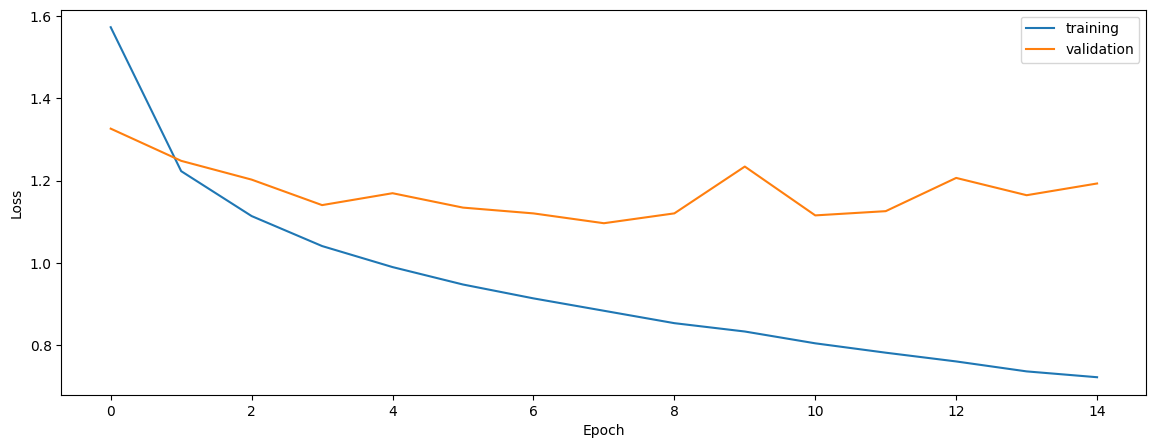

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6691793043699429
0.6030054270706267
0.48169671827199406


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.5991317419007448
0.5698159943382873
0.501455223880597


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.625521278252124
0.6087870059965059
0.5484408474172816


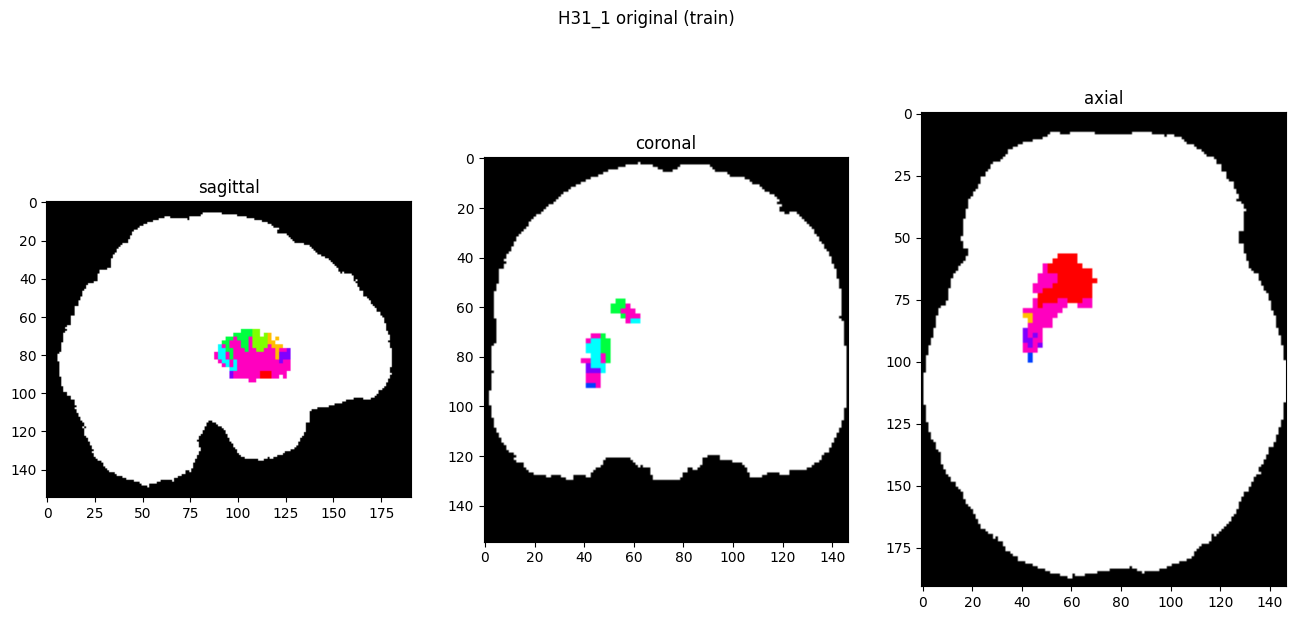

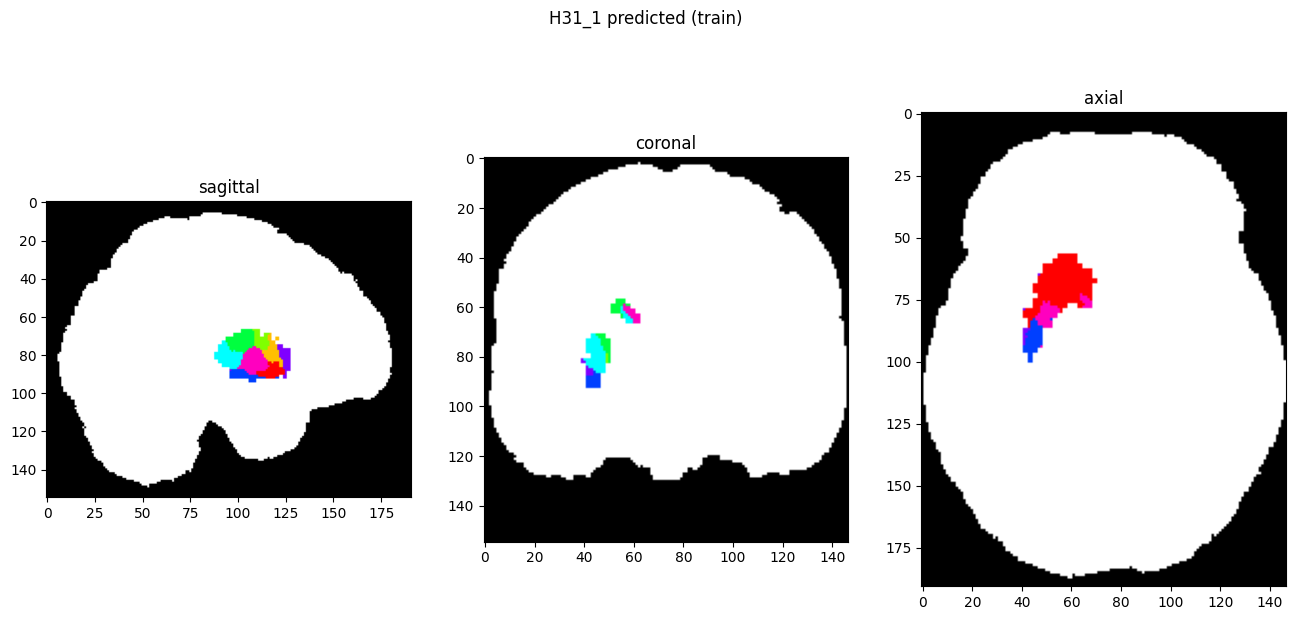

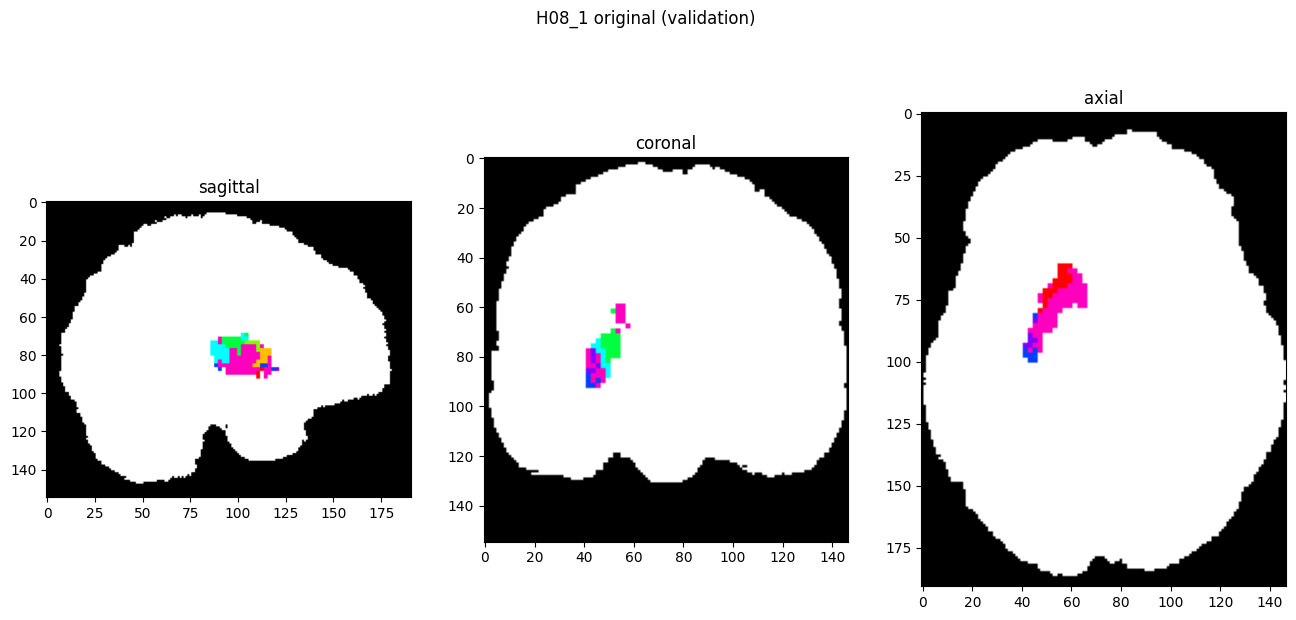

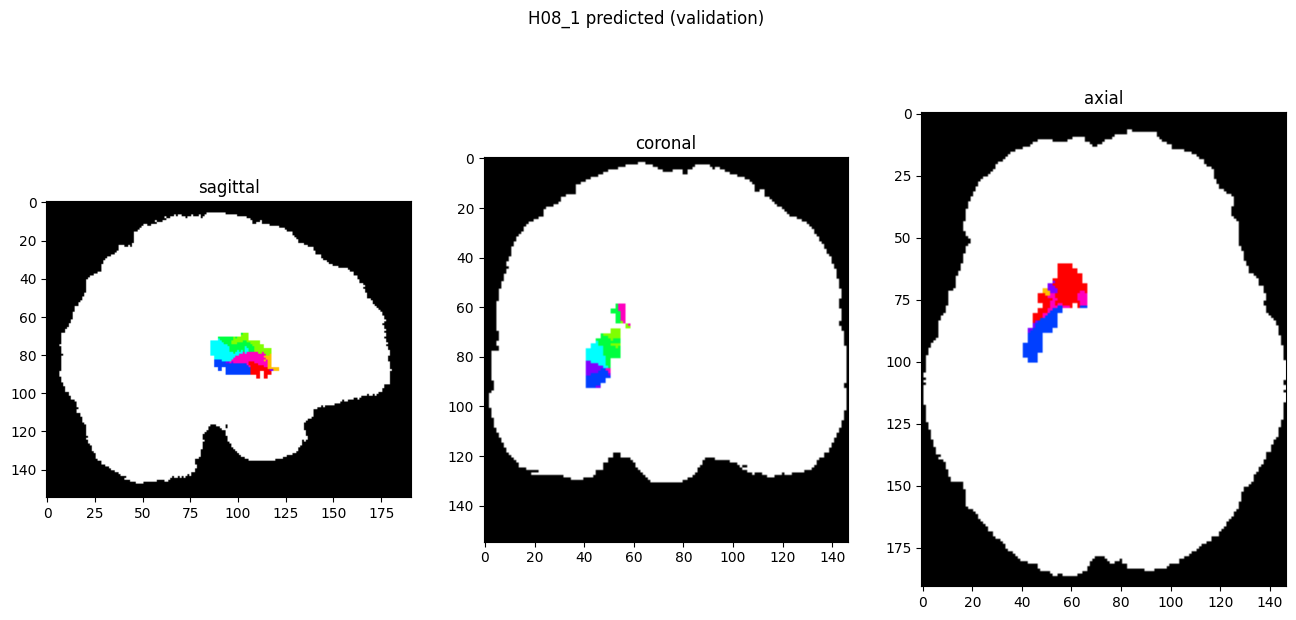

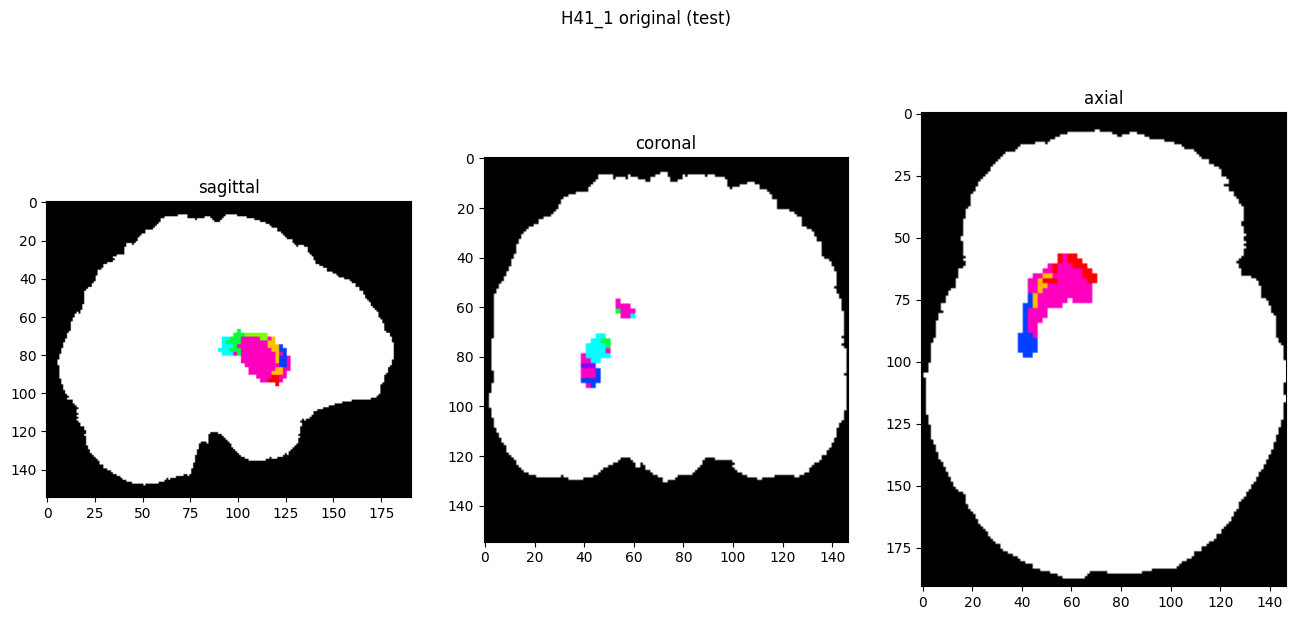

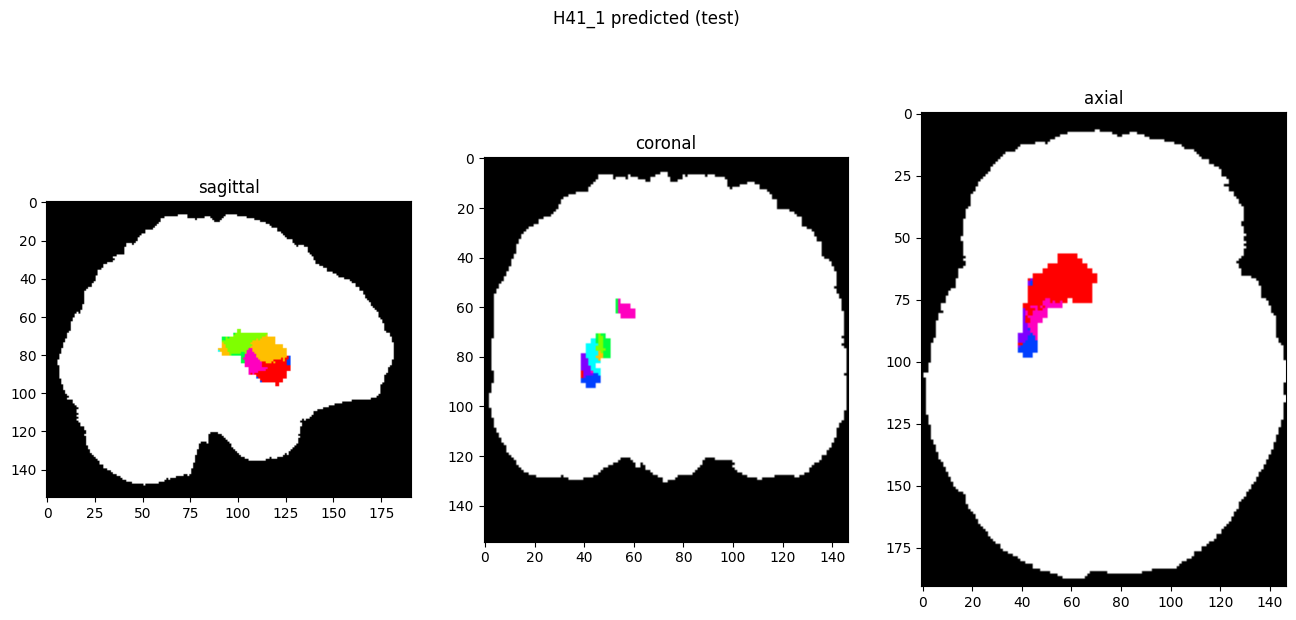

In [10]:
showResults(model, gen, threshold=0)